In [1]:
%load_ext pycodestyle_magic
%flake8_on
# la convention PEP8 est ainsi testée

Rédigé par Etienne Lardeur
2020, Projet 5 parcours Data Scientist - OpenClassrooms

# 1. Objectifs du projet

Nous cherchons à exploiter pour le compte d'Olist (solution de ventre sur les marketplaces en ligne), un historique de commande, afin de fournir aux équipes marketing une proposition de segmentation client. <br/>
<br/>
Le but est de :
- fournir une description de cette segmentation client dont l'équipe marketing pourra déduire des actions, 
- expliciter la logique sous-jacente, 
- vérifier les conditions de stabilité dans le temps des segments proposés et proposition de contrat de maintenance. <br/>
<br/>
Le présent notebook détaille l'ensemble des étapes d'analyse des données et de construction (en créant des features dérivés), d'un dataset centré clients assortis de découpages temporels, en vue de réaliser des segmentations et tester leur stabilité.

# 2. Structure des données

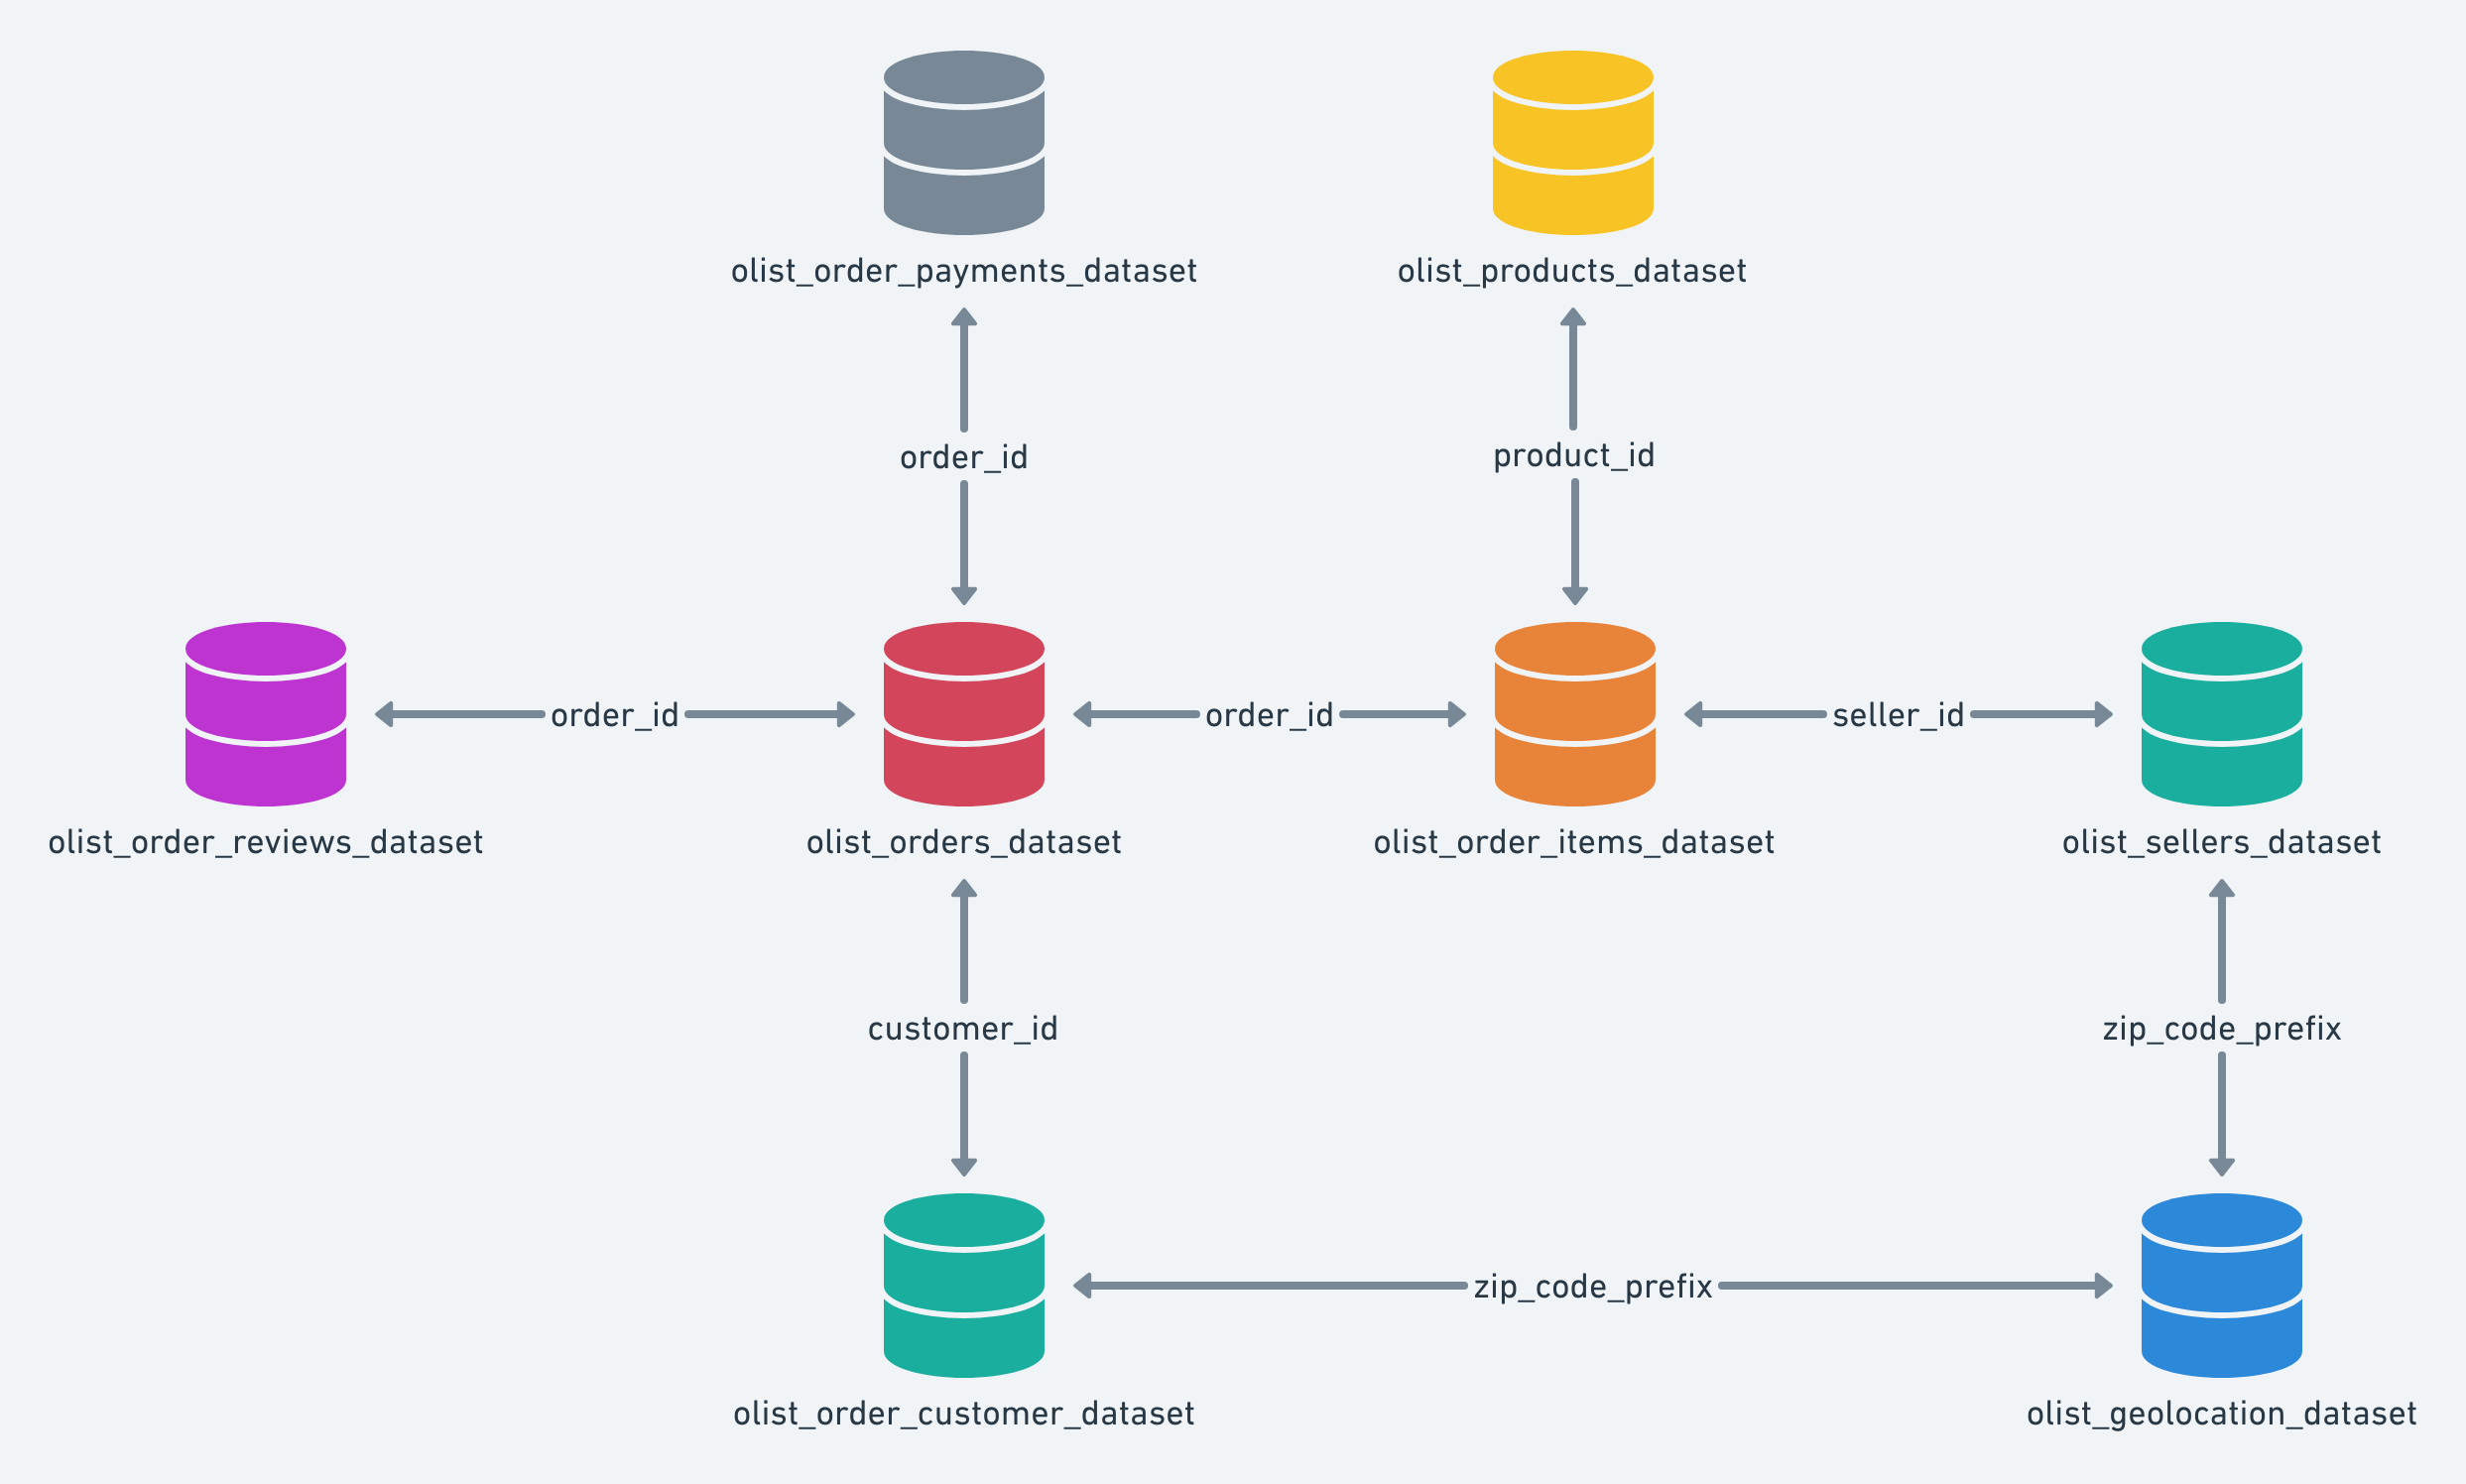

source {fig, datasets} : https://www.kaggle.com/olistbr/brazilian-ecommerce

Olist a mis a disposition les données sur Kaggle : y sont décrits les 8 datasets ainsi qu'un fichier product_category_name_translation. <br/>
Le schéma ci-dessus présente les datasets reliés par les clés indiquées.<br/>

En termes de cardinalités :
- les datasets sont fusionnables simplement avec une cardinalité 1:1 : cas de l'order_id depuis l'orders_dataset, mais également : customer_id, seller_id et product_id,
- un order est composé d'une liste de produits (1:n) via la notion d'items dans le datasets identifiant aussi le seller (1:1).
- un customerunique_id regroupe tous les customer_id associés en 1:1 à un order_id,
- le geolocation_dataset est associé via un zip_code_prefix, soit à un customer, soit à un seller. <br/>

Hors schéma, il reste une association simple des product_category_name en anglais qu'on exploitera pour une meilleure lisibilité.

In [2]:
%matplotlib inline
# importer les packages
# common
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.decomposition import PCA
# specific
from datetime import datetime
import time
# home made
import functions
from functions import distribution
# paramètres
sns.set(style="ticks")
sns.set_style('whitegrid')

In [3]:
# créer les dataframes correspondants aux données
df_customers = pd.read_csv('Data/olist_customers_dataset.csv')
df_orders = pd.read_csv('Data/olist_orders_dataset.csv')
df_items = pd.read_csv('Data/olist_order_items_dataset.csv')
df_products = pd.read_csv('Data/olist_products_dataset.csv')
df_payments = pd.read_csv('Data/olist_order_payments_dataset.csv')
df_sellers = pd.read_csv('Data/olist_sellers_dataset.csv')
df_reviews = pd.read_csv('Data/olist_order_reviews_dataset.csv')
df_geolocation = pd.read_csv('Data/olist_geolocation_dataset.csv')
df_translation = pd.read_csv('Data/product_category_name_translation.csv')

In [4]:
# créer le dict des datasets
datasets = {
    'Orders': df_orders,
    'Items': df_items,
    'Customers': df_customers,
    'Payments': df_payments,
    'Products': df_products,
    'Sellers': df_sellers,
    'Reviews': df_reviews,
    'Geolocation': df_geolocation,
    'Translation': df_translation,
}

In [5]:
# observer les tailles des datasets
for x, y in datasets.items():
    print(f'{x} shape is : ' f'{list(y.shape)}')

Orders shape is : [99441, 8]
Items shape is : [112650, 7]
Customers shape is : [99441, 5]
Payments shape is : [103886, 5]
Products shape is : [32951, 9]
Sellers shape is : [3095, 4]
Reviews shape is : [100000, 7]
Geolocation shape is : [1000163, 5]
Translation shape is : [71, 2]


Les données de 100 000 Commandes environ ont été mises à disposition.

In [6]:
ref = df_orders.shape[0]

# 3. Pertinence du recentrage sur le Client
Au vu du but recherché le principe est de construire des features caractérisant le Client, i.e. d'aggréger des données synthétiques au Customer_unique_id.<br/>
Dans cette logique, il faut opérer la sélection et le traitement des informations à "remonter" vers le Client au fil des liens d'association et cardinalité successifs.<br/>
Nous allons d'abord observer le triptyque Commande - Article - Client et son "recentrage" sur le Client.

## 3.1. Aperçu des données Clients

In [7]:
# aperçu des données customers
df_customers.sample(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
3898,1755f2846673a250cf4013174dfaad38,19b0839f7a896861cff91c416fdcf911,21940,rio de janeiro,RJ
85245,d81352b3fa189b687428ee79b94491a7,aff1a2ccef42609734df1e8ae42feb91,78025,cuiaba,MT
46031,44e5f9a2ba4c1849c4c70c5c8eedd011,fdfdc768c7e4add4875c623c9e146b3f,20780,rio de janeiro,RJ


In [8]:
# compter le nombre de clients
df_customers['customer_unique_id'].unique().size

96096

Les données sont anonymisées et sommaires : la localisation {ville, état} reliée à une {lat, lng} via un code, ainsi que le customer_unique_id qui  regroupe tous les customer_id eux-mêmes reliés aux order_id. 

In [9]:
# compter le nb d'achat par client
df_customers_purchase = df_customers.groupby(
    'customer_unique_id',
    as_index=False).agg({'customer_id': ['count']})
df_customers_purchase.columns = ['customer_unique_id',
                                 'order_count']

In [10]:
# afficher les 10 clients ayant effectué le plus de commandes
df_customers_purchase = df_customers_purchase.sort_values(by='order_count',
                                                          ascending=False)
df_customers_purchase[:10]

,customer_unique_id,order_count
52973,8d50f5eadf50201ccdcedfb9e2ac8455,17
23472,3e43e6105506432c953e165fb2acf44c,9
37797,6469f99c1f9dfae7733b25662e7f1782,7
76082,ca77025e7201e3b30c44b472ff346268,7
10354,1b6c7548a2a1f9037c1fd3ddfed95f33,7
7175,12f5d6e1cbf93dafd9dcc19095df0b3d,6
83540,de34b16117594161a6a89c50b289d35a,6
37585,63cfc61cee11cbe306bff5857d00bfe4,6
90451,f0e310a6839dce9de1638e0fe5ab282a,6
27043,47c1a3033b8b77b3ab6e109eb4d5fdf3,6


In [11]:
# moyenne des commandes par client
df_customers_purchase['order_count'].mean()

1.0348089410589412

In [12]:
# nombre de clients pour lesquels on détient l'information de 2 achats ou plus
df_customers_purchase[df_customers_purchase['order_count'] > 1].shape

(2997, 2)

In [13]:
# pourcentage des clients multi-acheteurs
print(round(100 *
            df_customers_purchase[df_customers_purchase['order_count'] >
                                  1].shape[0] /
            df_customers_purchase.shape[0], 2)) 

3.12


In [14]:
# aggréger le nb d'achats effectués pour chaque client unique
df_customers = df_customers.merge(
    df_customers_purchase,
    how='left',
    left_on=['customer_unique_id'],
    right_on=['customer_unique_id'])

In [15]:
# observer le résultat
df_customers.sample(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_count
70076,bb12662d89eaf5e7cfc75d41c18fd7a3,868d2b88ac8cd6ece5bfabb45486ac78,4863,sao paulo,SP,1
72479,861c4eff6dcc1cd1ce85c4d47fd54509,61bd25cfb1d871f63db30ea20530c223,47850,luis eduardo magalhaes,BA,1
35233,b06e7b4f481cd5e5f25b4a99a911d15c,72421b30e46c895e99e8560a48a33fb6,81110,curitiba,PR,2


## 3.2. Limitation des données
Nous constatons seulement 3 % d'acheteurs récurrents dans les données mises à disposition. <br/>
L'application de la méthode de segmentation RFM (Récence, Fréquence, Montant) est très largement compromise par cette troncature des données. 
En effet, en termes de segmentation, si des commandes ont été retirées pour la majorité des clients on retrouvera logiquement un groupe de clients étant fictivement les seuls à avoir réalisé plusieurs achats (Fréquence). <br/>
Par ailleurs, l'analyse de l'intervalle entre 2 achats risque de ne pas être représentative au moins quantitativement (Fréquence). <br/>
Enfin, le découpage dans le temps sans données longitudinales rend caduque la notion d'ancienneté client (Récence). <br/>

## 3.3. Aggrégation sur la Commande
Nous nous efforcerons donc de produire pour le marketing une caractéristation "directe" d'un nouveau client, en limitant autant que possible le biais d'une nouvelle troncature de donnée, selon la façon de retenir une commande unique par client (ex. la dernière commande effectuée, le produit le plus cher, etc.). <br/>

In [16]:
# contrôler les données manquantes
df_customers.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
order_count                 0
dtype: int64

# 4. La Commande au centre des données

In [17]:
# aperçu des données orders
df_orders.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00


La Commande est bien le centre initial et privilégié des données : elle permet de remonter aux Produits et aux Vendeurs via la notion d'Article (Item, qui représente le panier acheté). Elle est reliée directement aux Clients, aux Paiements et aux Avis. <br/>
Le processus pour chaque commande est détaillé (order_status et dates associées), à commencer par la date et l'heure d'achat. <br/>
Ces données temporelles permettent d'appréhender la période couverte et d'étudier la stabilité de la segmentation. <br/>
Nous passons en revue les éléments de la commande et des données reliées, susceptibles de caractériser le Client.

## 4.1. Order Status : filtrer les Commandes échues

In [18]:
# lister les valeurs possibles de l'order_status
df_orders['order_status'].unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

Text(0.5, 1.02, 'Order Status')

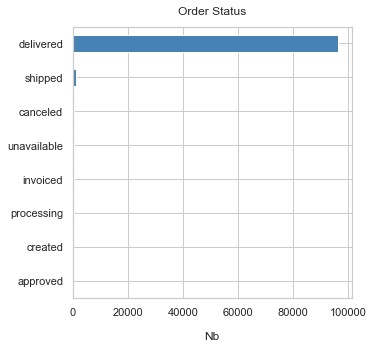

In [19]:
# observer la répartition des commandes par status
df_orders['order_status'].value_counts().plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Nb', labelpad=14)
plt.title('Order Status', y=1.02)

On choisit de retirer les commandes "en cours" et retirer les commandes non disponibles ou annulées (qui peuvent faire l'objet d'une attention client spécifique).

In [20]:
# retirer les commandes en cours
df_orders = df_orders[df_orders['order_status'] == 'delivered']
print(df_orders.shape)

(96478, 8)


In [21]:
# détecter les valeurs manquantes
df_orders.isna().sum()

order_id                          0
customer_id                       0
order_status                      0
order_purchase_timestamp          0
order_approved_at                14
order_delivered_carrier_date      2
order_delivered_customer_date     8
order_estimated_delivery_date     0
dtype: int64

In [22]:
# retirer les valeurs manquantes et controler la taille résultante
df_orders = df_orders.dropna().copy()
print(df_orders.shape)

(96455, 8)


In [23]:
print(ref-df_orders.shape[0])

2986


## 4.2. Order process : exploiter les dates de Commande
Le processus de commande va permettre d'observer les volumes de commandes sur la période mise à disposition.

In [24]:
# s'assurer du format des informations dates
for col in ['order_purchase_timestamp',
            'order_approved_at',
            'order_delivered_carrier_date',
            'order_delivered_customer_date',
            'order_estimated_delivery_date']:
    df_orders[col] = pd.to_datetime(df_orders[col],
                                    format='%Y-%m-%d %H:%M:%S')

In [25]:
# décomposer la date d'achat en donnée année, mois, jour, heure
df_orders['order_purchase_year'] =\
    df_orders.order_purchase_timestamp.apply(lambda x: x.year)
df_orders['order_purchase_month'] =\
    df_orders.order_purchase_timestamp.apply(lambda x: x.month)
df_orders['order_purchase_day'] =\
    df_orders.order_purchase_timestamp.apply(lambda x: x.day)
df_orders['order_purchase_dayofweek'] =\
    df_orders.order_purchase_timestamp.apply(lambda x: x.dayofweek)
df_orders['order_purchase_hour'] =\
    df_orders.order_purchase_timestamp.apply(lambda x: x.hour)
# identifier par son libellé, le moi et le jour de la semaine
df_orders['order_purchase_month_label'] =\
    df_orders.order_purchase_month.map({1: 'Jan',
                                        2: 'Feb',
                                        3: 'Mar',
                                        4: 'Apr',
                                        5: 'May',
                                        6: 'Jun',
                                        7: 'Jul',
                                        8: 'Aug',
                                        9: 'Sep',
                                        10: 'Oct',
                                        11: 'Nov',
                                        12: 'Dec'})
df_orders['order_purchase_dayofweek_label'] =\
    df_orders.order_purchase_dayofweek.map({0: 'Mon',
                                            1: 'Tue',
                                            2: 'Wed',
                                            3: 'Thu',
                                            4: 'Fri',
                                            5: 'Sat',
                                            6: 'Sun'})

### 4.2.1. Commandes mensuelles au cours du temps

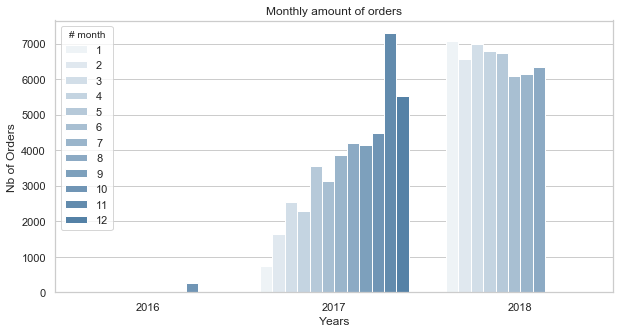

In [26]:
# afficher l'évolution des commandes
plt.figure(figsize=(10, 5))
ax = sns.countplot(x='order_purchase_year',
                   hue='order_purchase_month',
                   data=df_orders,
                   color='Steelblue')
ax.set(xlabel='Years',
       ylabel='Nb of Orders',
       title='Monthly amount of orders')
plt.legend(title='# month', loc='upper left')
plt.show()

Nous disposons à compter de Janvier 2018, d'une quantité de commande stable jusqu'au mois d'Aout 2018. Les 13 mois qui précèdent montrent une augmentation monotone à l'exception d'un probable surnombre de commandes en Novembre 2017. <br/>
Nous pouvons envisager de construire une segmentation sur la période 2017 et tester sa stabilité en injectant un par un les 8 mois suivants. <br/>

In [27]:
df_orders.sample(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_dayofweek,order_purchase_hour,order_purchase_month_label,order_purchase_dayofweek_label
19018,9b0ca49107c50799985679a726bfd9f1,338a88863afef428379f400aaf88ebb0,delivered,2018-01-21 16:32:51,2018-01-22 13:53:41,2018-01-24 12:08:03,2018-01-31 23:46:37,2018-02-15,2018,1,21,6,16,Jan,Sun
77689,c9c76a6cf34575ea054a043a4d03c0a1,92c225f7c50be5d7a6fc60dd0b750dc7,delivered,2018-08-16 09:52:01,2018-08-17 09:49:52,2018-08-17 13:17:00,2018-08-25 10:26:25,2018-08-23,2018,8,16,3,9,Aug,Thu
12146,8c007d0c7bfabe041dd7bc0514210ed9,e9a8ec739f5a59dece9f715ef4c8aa3d,delivered,2018-04-16 17:24:04,2018-04-16 18:55:26,2018-04-19 00:16:51,2018-05-10 19:51:27,2018-05-16,2018,4,16,0,17,Apr,Mon


In [28]:
# créer / actualiser les commandes réparties par année
orders_2017 = df_orders[(df_orders['order_purchase_year'] == 2017) |
                        (df_orders['order_purchase_year'] == 2016)]
orders_2018 = df_orders[(df_orders['order_purchase_year'] == 2018)]

On observe donc deux périodes : la période transitoire "2017" qui correspond à une montée en charge, et la période stabilisée "2018".
Du fait de la troncature manifestement opérée sur les données, la transition ou la stabilité peuvent être mises en doute.

### 4.2.2. Moment d'achat

Nous allons observer les commandes au fil des jours du mois et au fil de la semaine :<br/>
Le Client pouvant être caractérisé par le moment privilégié de la journée, de la semaine ou du mois où il effectue ses achats.<br/>

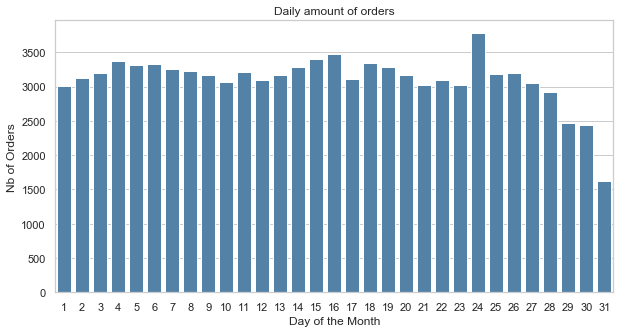

In [29]:
# afficher l'évolution des commandes selon les jours du mois (en cumul)
plt.figure(figsize=(10, 5))
ax = sns.countplot(x='order_purchase_day',
                   data=df_orders,
                   color='Steelblue')
ax.set(xlabel='Day of the Month',
       ylabel='Nb of Orders',
       title='Daily amount of orders')
plt.show()

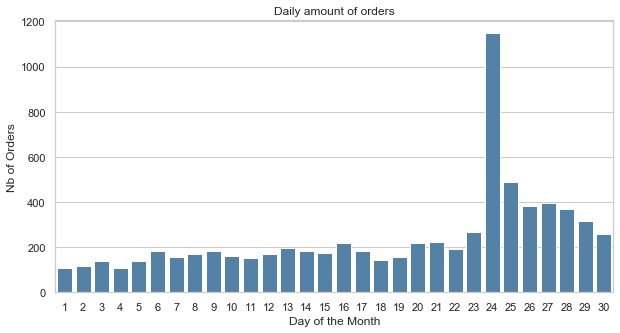

In [30]:
# confirmer le pic de commandes 11/2017
plt.figure(figsize=(10, 5))
ax = sns.countplot(x='order_purchase_day',
                   data=df_orders[(df_orders['order_purchase_year'] == 2017) &
                                  (df_orders['order_purchase_month'] == 11)],
                   color='Steelblue')
ax.set(xlabel='Day of the Month',
       ylabel='Nb of Orders',
       title='Daily amount of orders')
plt.show()

Excepté le 24 novembre 2017, nous ne constatons pas de grande variation et le plus faible nombre de commandes constatées un 31ème jour du mois est trivial.

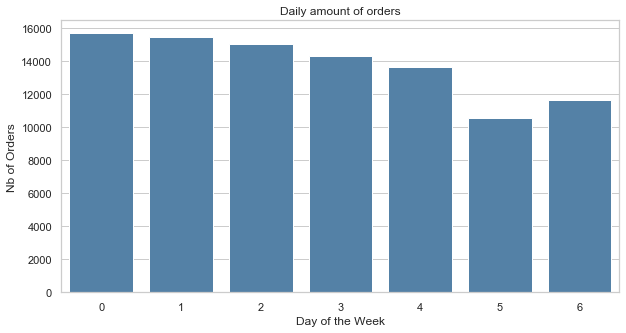

In [31]:
# afficher l'évolution des commandes selon les jours de la semaine
plt.figure(figsize=(10, 5))
ax = sns.countplot(x='order_purchase_dayofweek',
                   data=df_orders,
                   color='Steelblue')
ax.set(xlabel='Day of the Week',
       ylabel='Nb of Orders',
       title='Daily amount of orders')
plt.show()

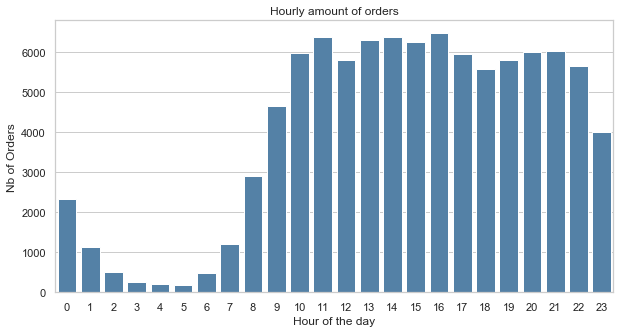

In [32]:
# afficher l'évolution des commandes selon les heures de la journée
plt.figure(figsize=(10, 5))
ax = sns.countplot(x='order_purchase_hour',
                   data=df_orders,
                   color='Steelblue')
ax.set(xlabel='Hour of the day',
       ylabel='Nb of Orders',
       title='Hourly amount of orders')
plt.show()

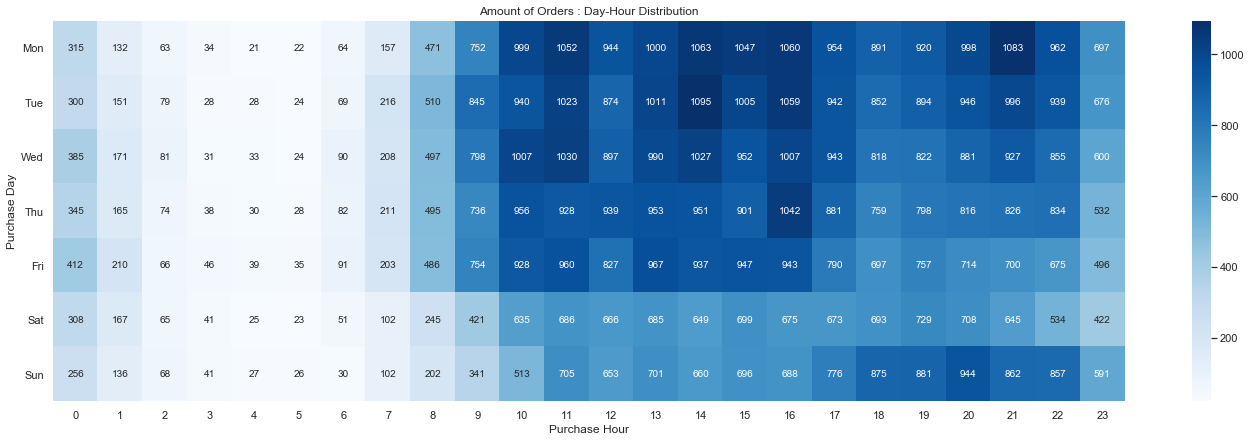

In [33]:
# afficher la répartition des commandes par heure et jour d'achat
order_count = df_orders.groupby(['order_purchase_dayofweek',
                                 'order_purchase_hour'])\
    .count()['order_id'].unstack()
plt.figure(figsize=(24, 7))
ax = sns.heatmap(order_count, cmap='Blues', annot=True, fmt='d')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set(xlabel='Purchase Hour',
       ylabel='Purchase Day',
       yticklabels=(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']),
       title='Amount of Orders : Day-Hour Distribution')
for item in ax.get_yticklabels():
    item.set_rotation(0)
plt.show()

Nous obtenons des périodes d'une heure pour lesquelles la quantité de commande peut varier de quelques unités à plus d'un millier (en cumul sur près de 2 ans) : nous dégageons des zones temporelles.

### 4.2.3. Découpage du moment d'achat en zone temporelles

Pour effectuer ce découpage, nous nous appuyons sur la visualisation des décomptes par heure - jour qu'offre une clustermap, c'est à dire une heatmap dont les données sont organisées à partir d'un clustering hiérarchique.
Après test les différentes méthodes de clustering et métriques de calcul des distances (lorsqu'elles sont viables) présentent des résultats similaires.

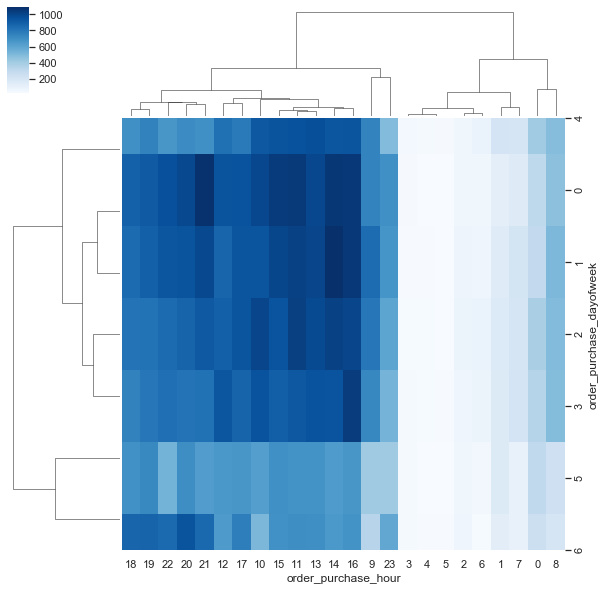

In [34]:
# afficher une clustermap pour définir les zones temporelles
sns.clustermap(order_count, cmap='Blues', method='median', metric='euclidean')
plt.show()

Le clustering fait apparaitre très clairement le découpage Working-Day / Week-End, ainsi que Day - Night. <br/>
On observe une distinctionpour 9h et 23h, mais qui ont moins de sens à être dissociés que l'usuelle distinction Day-Evening qui apparait juste après. <br/>

Il y a deux niveaux de compromis possibles, selon qu'on aménage ou non une distinction AM - PM qui a l'avantage de répartir les effectifs de commandes de manière plus équitable et d'être facilement actionnable / interprétable pour des visées marketing.

On retient dans ce cas 4 à 5 time zones :
- "Night", creuse quelque soit le jour de la semaine, couvrant la période [0h-8h],
- "WE", week-end,
- "Day" [9h-17h] et "Evening-WD" [18h-23h],
- en coupant "Day" par la distinction usuelle "AM" [9h-12h] et "PM" [13h-17h].


In [35]:
# distinguer nuit, am, pm, evening
df_orders['time_zone_hour'] =\
    df_orders.order_purchase_hour.map({0: 'Night',
                                       1: 'Night',
                                       2: 'Night',
                                       3: 'Night',
                                       4: 'Night',
                                       5: 'Night',
                                       6: 'Night',
                                       7: 'Night',
                                       8: 'AM',
                                       9: 'AM',
                                       10: 'AM',
                                       11: 'AM',
                                       12: 'AM',
                                       13: 'PM',
                                       14: 'PM',
                                       15: 'PM',
                                       16: 'PM',
                                       17: 'PM',
                                       18: 'Evening',
                                       19: 'Evening',
                                       20: 'Evening',
                                       21: 'Evening',
                                       22: 'Evening',
                                       23: 'Evening'})

In [36]:
# distinguer week et week-end
df_orders['time_zone_day'] =\
    df_orders.order_purchase_dayofweek.map({0: 'WD',
                                            1: 'WD',
                                            2: 'WD',
                                            3: 'WD',
                                            4: 'WD',
                                            5: 'WE',
                                            6: 'WE'})

In [37]:
# construire les 3 zones WD : AM, PM et Evening
df_orders['purchase_time_zone'] = df_orders['time_zone_hour'] + '-' + df_orders['time_zone_day']

In [38]:
# construire la time zone WE
df_orders['purchase_time_zone'][df_orders['time_zone_day'] == 'WE'] = 'WE'

C:\Users\etien\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [39]:
# construire la time zone Night
df_orders['purchase_time_zone'][df_orders['time_zone_hour'] == 'Night'] = 'Night'

C:\Users\etien\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [40]:
# contrôler la liste de time zone construites
df_orders['purchase_time_zone'].unique()

array(['AM-WD', 'Evening-WD', 'WE', 'PM-WD', 'Night'], dtype=object)

In [299]:
# transformer en feature catégoriel
df_orders['purchase_time_zone'] = df_orders['purchase_time_zone'].astype('category')

Text(0.5, 1.02, 'Purchase Time Zones')

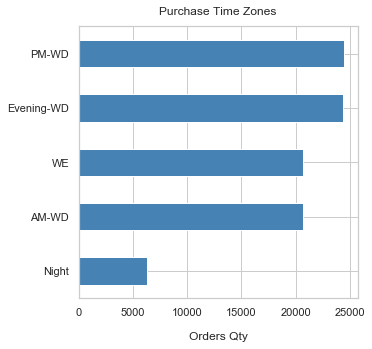

In [41]:
# observer la répartition des commandes par purchase_time_zone
df_orders['purchase_time_zone'].value_counts().plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Orders Qty', labelpad=14)
plt.title('Purchase Time Zones', y=1.02)

In [42]:
df_orders.sample(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_dayofweek,order_purchase_hour,order_purchase_month_label,order_purchase_dayofweek_label,time_zone_hour,time_zone_day,purchase_time_zone
93756,a979f259e3f69ceb4f856111481db7e7,36c97de8d5d1c683eb313ee1a4277ca5,delivered,2018-01-31 17:51:57,2018-01-31 18:08:17,2018-02-02 19:04:50,2018-02-07 22:23:34,2018-03-01,2018,1,31,2,17,Jan,Wed,PM,WD,PM-WD
82199,ce3397e3e383fc93adefff9aa6a9aa7b,c921549d3338d9ae7d718a63a49478a4,delivered,2017-11-07 15:02:12,2017-11-09 04:31:15,2017-11-16 23:16:51,2017-11-20 12:22:04,2017-11-27,2017,11,7,1,15,Nov,Tue,PM,WD,PM-WD
92312,930ce01cc6b66e9582938cc79f835ffe,cb12f7cafbef496e37dc4d089281b2e4,delivered,2018-05-03 16:55:44,2018-05-05 03:35:20,2018-05-08 06:32:00,2018-05-14 16:44:46,2018-06-08,2018,5,3,3,16,May,Thu,PM,WD,PM-WD


### 4.2.4. Délais de livraison et retard

Le comportement futur du client, et plus directement le review score qu'il donnera à réception de l'article, peut être affecté par l'écart de date de livraison effective / estimée et dans une moindre mesure par le délai d'approbation de sa commande (ce dernier est réduit et standard et ne sera donc pas considéré à ce stade).<br/>

In [43]:
# calculer le délai de livraison annoncé
df_orders['estimated_delivery_time'] =\
    (df_orders['order_estimated_delivery_date'] -
     df_orders['order_purchase_timestamp']).dt.days

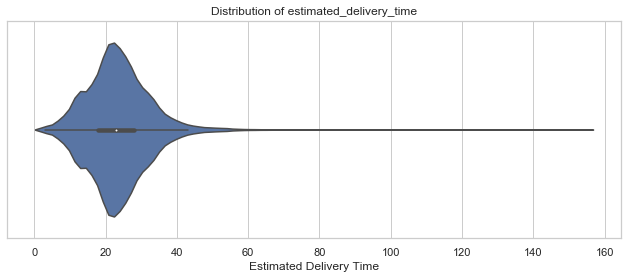

Délai moyen de livraison annoncé en jours : 23


In [44]:
# afficher la distribution de délais de livraison estimé / annoncé
distribution(df_orders,
             'estimated_delivery_time',
             'Estimated Delivery Time',
             'violin')
print('Délai moyen de livraison annoncé en jours : ' +
      str(round(df_orders['estimated_delivery_time'].mean())))

On observe des délais annoncés extrêmes. Le processus de commande n'est plus nominal, comme c'est le cas par exemple pour des articles en rupture de stock, où le délai estimé est forcément erroné si les délais de fabrication ne sont pas maîtrisés.

In [45]:
# calculer le délai de livraison effectif
df_orders['effective_delivery_time'] =\
    (df_orders['order_delivered_customer_date'] -
     df_orders['order_purchase_timestamp']).dt.days

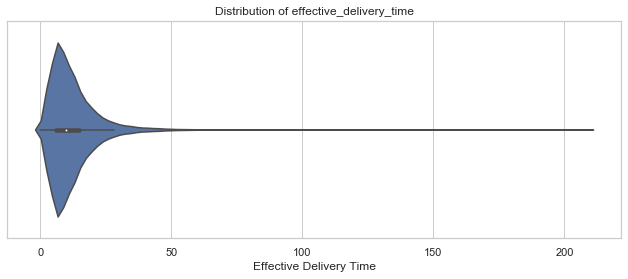

Délai moyen effectif de livraison en jours : 12


In [46]:
# afficher la distribution des délais de livraison effectif
distribution(df_orders,
             'effective_delivery_time',
             'Effective Delivery Time',
             'violin')
print('Délai moyen effectif de livraison en jours : ' +
      str(round(df_orders['effective_delivery_time'].mean())))

In [47]:
# nombre de livraison sous 24h
df_orders[df_orders['effective_delivery_time'] == 0].shape

(13, 20)

In [48]:
# calculer l'écart entre la livraison réelle et prévue (en jours d'avance)
df_orders['delivery_vs_estimated'] =\
    (df_orders['order_estimated_delivery_date'] -
     df_orders['order_delivered_customer_date']).dt.days

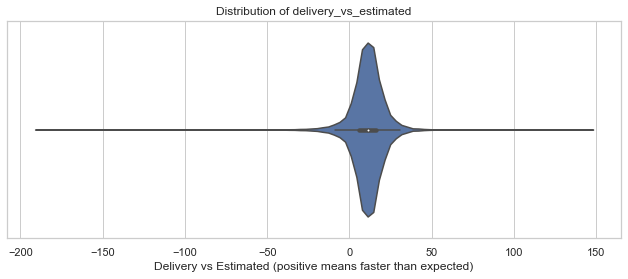

Ecart moyen entre le délai de livraison effective et estimé : 11


In [49]:
# afficher la distribution de l'écart de délai de livraison
distribution(df_orders,
             'delivery_vs_estimated',
             'Delivery vs Estimated (positive means faster than expected)',
             'violin')
print('Ecart moyen entre le délai de livraison effective et estimé : ' +
      str(round(df_orders['delivery_vs_estimated'].mean())))

Les clients reçoivent en général leur commande 11 jours avant la date estimée, qui est de fait estimée au delà des délais nominaux de préparation - expédition - transport - livraison. 

Bien que le client ne le "sache" pas, le délai qui lui est annoncé est régulièrement honoré à la moitié ou presque, ou à l'inverse, on lui annonce en moyenne le double du délai que prendrait réellement la livraison en moyenne. <br/>
Cela implique de construire une indication corrigée de l'écart de délai de livraison, et par exemple considérer l'écart de livraison par rapport à la valeur moyenne. <br/>

In [50]:
# créer / actualiser les commandes répartes par année
orders_2017 = df_orders[(df_orders['order_purchase_year'] == 2017) |
                        (df_orders['order_purchase_year'] == 2016)]
orders_2018 = df_orders[(df_orders['order_purchase_year'] == 2018)]

In [51]:
# observer la variation éventuelle entre 2017 et 2018
print('Variation delivery_vs_estimated entre 2017 (ref) et 2018 : ' +
      str(round(orders_2017['delivery_vs_estimated'].mean() - orders_2018['delivery_vs_estimated'].mean())))

Variation delivery_vs_estimated entre 2017 (ref) et 2018 : 1


Les cas extrêmes observés produise des situations incohérentent qui remettent en cause la fiabilité de la date annoncé. <br/>
Ils portent sur une faible quantité de commandes. <br/>
On décide de filtrer sur la base du délai estimé, en vertu du principe qu'il n'est pas maîtrisé dans ce cas (délai de fabrication) et qu'il fera l'objet d'un suivi spécifique.

In [52]:
# calcul du 99ème percentile pour le délai estimé
np.percentile(df_orders['estimated_delivery_time'], 99)

50.0

In [53]:
# contrôler la quantité d'outliers considérés
df_orders[df_orders['estimated_delivery_time'] >= 50].shape

(1001, 21)

In [54]:
# calcul du 99ème percentile pour le délai effectif
np.percentile(df_orders['effective_delivery_time'], 99)

46.0

In [55]:
# contrôler la quantité d'outliers considérés
df_orders[df_orders['effective_delivery_time'] >= 45].shape

(1091, 21)

In [56]:
# retirer les outliers
df_orders = df_orders[df_orders['estimated_delivery_time'] < 50]
df_orders = df_orders[df_orders['effective_delivery_time'] < 45]

In [57]:
# contrôler le nb de commandes
df_orders.shape

(94422, 21)

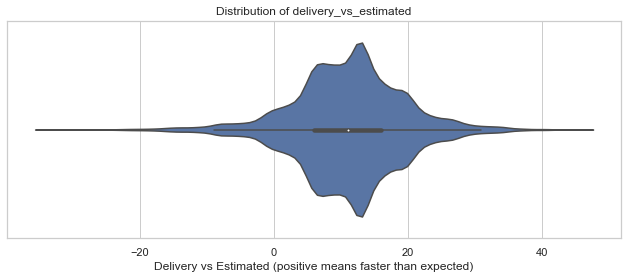

Ecart moyen entre le délai de livraison effective et estimé : 11


In [58]:
# afficher la distribution de l'écart de délai de livraison
distribution(df_orders,
             'delivery_vs_estimated',
             'Delivery vs Estimated (positive means faster than expected)',
             'violin')
print('Ecart moyen entre le délai de livraison effective et estimé : ' +
      str(round(df_orders['delivery_vs_estimated'].mean())))

Au vu de cette répartition, on opte pour une séparation en 3 : nominal, sooner and later.

In [59]:
df_orders['delivery_vs_estimated_lvl'] = pd.qcut(
    df_orders['delivery_vs_estimated'],
    3,
    labels=['Later_Delivery',
            'Nominal_Delivery',
            'Sooner_Delivery'])

Text(0.5, 1.02, 'Delivery Delay Levels')

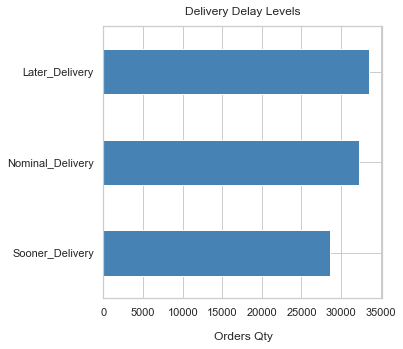

In [60]:
# observer la répartition des retard ou avance de livraison
df_orders['delivery_vs_estimated_lvl'].value_counts().plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Orders Qty', labelpad=14)
plt.title('Delivery Delay Levels', y=1.02)

In [61]:
# retirer les valeurs manquantes et controler la taille résultante
df_orders = df_orders.dropna().copy()
print(df_orders.shape)

(94422, 22)


In [62]:
# retirer les colonnes obsolètes
df_orders = df_orders.drop(
    columns=['order_status',
             'order_approved_at',
             'order_delivered_carrier_date',
             'order_delivered_customer_date',
             'order_estimated_delivery_date'])

In [63]:
# aperçu des données orders
df_orders.head(3)

,order_id,customer_id,order_purchase_timestamp,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_dayofweek,order_purchase_hour,order_purchase_month_label,order_purchase_dayofweek_label,time_zone_hour,time_zone_day,purchase_time_zone,estimated_delivery_time,effective_delivery_time,delivery_vs_estimated,delivery_vs_estimated_lvl
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017,10,2,0,10,Oct,Mon,AM,WD,AM-WD,15,8,7,Later_Delivery
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,2018,7,24,1,20,Jul,Tue,Evening,WD,Evening-WD,19,13,5,Later_Delivery
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,2018,8,8,2,8,Aug,Wed,AM,WD,AM-WD,26,9,17,Sooner_Delivery


# 5. Les articles (Items & Products)

Le dataset items relie la commande (order) aux produits (products) : il détaille le "panier" d'articles commandés, et pour lesquels sont définis le vendeur, le prix, le coût de livraison, une éventuelle date limite d'envoi.<br/>
Tandis que le dataset Products définis les caractéristiques unitaires de catégorie, taille, poids et description de l'article. <br/>
On retrouve la quantité achetée car les produits sont listés unitairement.

## 5.1. Items (articles d'un panier)

In [64]:
# aperçu des données Items
df_items.sample(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
83300,bd33d6543dab80671198f9df40e3411d,1,ecf9484703bdfb9cfcc1ac9c2084b567,59b22a78efb79a4797979612b885db36,2018-04-02 13:47:53,265.0,54.05
4842,0aed18a03ea2ccdb5981aea3524b304d,2,08574b074924071f4e201e151b152b4e,001cca7ae9ae17fb1caed9dfb1094831,2017-09-18 04:55:21,99.0,52.71
98490,df638e8bbe2b487525b22f5c7a5c9231,1,195d8e91830247a20eee5eb4c4236294,a5cba26a62b8b4d0145b68b841e62e7f,2018-02-26 17:28:07,279.0,16.70


La date limite d'envoi est une information attachée au panier complétant les délais renseignés, le délai d'envoi varie peu et sera ignoré.

In [65]:
# ordonner les articles par prix décroissants
df_items = df_items.sort_values(by=['order_id', 'price'],
                                ascending=False)

In [66]:
# compter le nb d'articles par commande
df_items_count = df_items.groupby(
    'order_id',
    as_index=False).agg({'order_item_id': ['max'],
                         'product_id': ['nunique']})
df_items_count.columns = ['order_id',
                          'items_qty',
                          'products_qty']

In [67]:
# afficher les 3 commandes avec le plus d'articles
df_items_count = df_items_count.sort_values(by='items_qty',
                                            ascending=False)
df_items_count[:3]

,order_id,items_qty,products_qty
50137,8272b63d03f5f79c56e9e4120aec44ef,21,3
10459,1b15974a0141d54e36626dca3fdc731a,20,1
65715,ab14fdcfbe524636d65ee38360e22ce8,20,1


In [68]:
#  quantités d'articles et nb d'articles différents
print('nb articles en moyenne par commande  : ' +
      str(round(df_items_count['items_qty'].mean(), 2)))
print('nb articles différents en moyenne par commande  : ' +
      str(round(df_items_count['products_qty'].mean(), 2)))

nb articles en moyenne par commande  : 1.14
nb articles différents en moyenne par commande  : 1.04


In [69]:
# scruter les commandes avec les plus grandes quantité d'articles
df_items[df_items['order_id'] == '8272b63d03f5f79c56e9e4120aec44ef']

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
57317,8272b63d03f5f79c56e9e4120aec44ef,21,79ce45dbc2ea29b22b5a261bbb7b7ee7,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,7.8,6.57
57297,8272b63d03f5f79c56e9e4120aec44ef,1,270516a3f41dc035aa87d220228f844c,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57298,8272b63d03f5f79c56e9e4120aec44ef,2,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57299,8272b63d03f5f79c56e9e4120aec44ef,3,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57300,8272b63d03f5f79c56e9e4120aec44ef,4,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57301,8272b63d03f5f79c56e9e4120aec44ef,5,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57302,8272b63d03f5f79c56e9e4120aec44ef,6,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57303,8272b63d03f5f79c56e9e4120aec44ef,7,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57304,8272b63d03f5f79c56e9e4120aec44ef,8,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57305,8272b63d03f5f79c56e9e4120aec44ef,9,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89


Il s'agit de quantités élevées d'un nombre réduit d'articles différent, ce qui tend à indiquer que c'est la nature du produit qui implique d'en commander une plus grande quantité, au contraire d'une diversité d'articles dans le panier de commande.

On observe que le coût de livraison semble s'ajouter pour chaque produit contrairement à ce qu'on imagine dans la réalité. <br/>

In [70]:
# nombre de commandes pour lesquelles il y 2 articles différents ou plus
df_items_count[df_items_count['products_qty'] > 1].shape

(3236, 3)

In [71]:
# dériver en un feature catégoriel les single_product ou multi_product (2 et +)
df_items_count['products_qty'] =\
    df_items_count['products_qty'].map(
    lambda x: 'multi_products' if x >= 2 else 'single_product')
# dériver en un feature catégoriel les single_product ou multi_product (2 et +)
df_items_count['items_qty'] =\
    df_items_count['items_qty'].map(
    lambda x: 'multi_items' if x >= 2 else 'single_item')

Text(0.5, 1.02, 'Single vs multi-products balance')

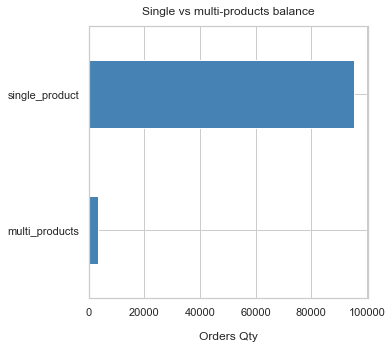

In [72]:
# observer la répartition des single et multi_product
df_items_count['products_qty'].value_counts().plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Orders Qty', labelpad=14)
plt.title('Single vs multi-products balance', y=1.02)

Text(0.5, 1.02, 'Single vs multi-items balance')

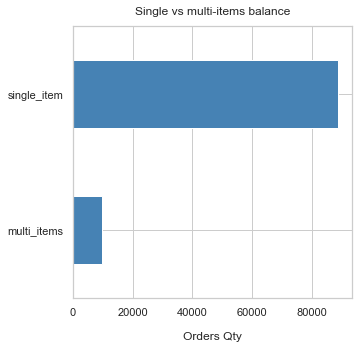

In [73]:
# observer la répartition des single et multi_product
df_items_count['items_qty'].value_counts().plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Orders Qty', labelpad=14)
plt.title('Single vs multi-items balance', y=1.02)

In [74]:
# aggréger aux commandes le nb d'articles
df_orders = df_orders.merge(
    df_items_count,
    how='left',
    left_on=['order_id'],
    right_on=['order_id'])

In [75]:
print(ref-df_orders.shape[0])
df_orders.sample(3)

5019


,order_id,customer_id,order_purchase_timestamp,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_dayofweek,order_purchase_hour,order_purchase_month_label,order_purchase_dayofweek_label,time_zone_hour,time_zone_day,purchase_time_zone,estimated_delivery_time,effective_delivery_time,delivery_vs_estimated,delivery_vs_estimated_lvl,items_qty,products_qty
39561,3237491ee1f51f346e175b2dc581b734,020f4af7eeabf986e31eb7ac4c6597cb,2018-04-28 13:22:03,2018,4,28,5,13,Apr,Sat,PM,WE,WE,19,5,14,Nominal_Delivery,single_item,single_product
28717,b6f543c68b695c88dd2d1e0f5c7528e9,e1fabfdec84ec2b60621a1dca9c4ecc0,2018-01-02 10:03:57,2018,1,2,1,10,Jan,Tue,AM,WD,AM-WD,28,6,22,Sooner_Delivery,single_item,single_product
13735,0f8cf123486438ffdee527bf82ec87d4,48edd605f2b0aa7b701d54771e388335,2017-02-03 11:58:30,2017,2,3,4,11,Feb,Fri,AM,WD,AM-WD,44,13,30,Sooner_Delivery,single_item,single_product


### 5.1.1.  Article principal de la commande

Au vu du faible de nombre de commandes multi-articles, l'idée est de résumer une commande à l'article le plus important, plutôt que de perdre le sens en fusionnant les caractéristiques des articles à ce stade. <br/>
On retient comme article le pus important, celui correspondant à la plus grosse dépense.

In [76]:
#  garder l'article le plus cher pour chaque commande
df_items_mip = df_items[['order_id', 'product_id']].drop_duplicates(
    subset='order_id',
    keep='first').copy()
# renommer le feature désignant le produit le plus important
df_items_mip = df_items_mip.rename(columns={'product_id': 'most_important_product'})

In [77]:
# vérifier un résultat
df_items_mip[df_items_mip['order_id'] == '8272b63d03f5f79c56e9e4120aec44ef']

,order_id,most_important_product
57317,8272b63d03f5f79c56e9e4120aec44ef,79ce45dbc2ea29b22b5a261bbb7b7ee7


In [78]:
# aggréger aux commandes l'article dans la plus grande quantité
df_orders = df_orders.merge(
    df_items_mip,
    how='left',
    left_on=['order_id'],
    right_on=['order_id'])

In [79]:
# contrôler le résultat
print(ref-df_orders.shape[0])
df_orders.sample(7)

5019


,order_id,customer_id,order_purchase_timestamp,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_dayofweek,order_purchase_hour,order_purchase_month_label,order_purchase_dayofweek_label,time_zone_hour,time_zone_day,purchase_time_zone,estimated_delivery_time,effective_delivery_time,delivery_vs_estimated,delivery_vs_estimated_lvl,items_qty,products_qty,most_important_product
8223,c8e51524cf9ae78ec9f421b1054378ff,735910d408209bc94a6b5cba4985425f,2017-10-08 12:40:00,2017,10,8,6,12,Oct,Sun,AM,WE,WE,31,16,15,Sooner_Delivery,single_item,single_product,47a3fbd41bb53db64dacc4562ba3aa52
85013,f3b6286e074ced4149f83f3b7fd95b3e,05d18f7033aeb69e03888511124a473e,2018-05-10 14:00:13,2018,5,10,3,14,May,Thu,PM,WD,PM-WD,11,7,3,Later_Delivery,single_item,single_product,cd5df6a3db7a3d064a55afd08289d762
1275,bf4f937c279d6f44c375450523ee9383,24fc6ae10363187c6761d4f8ad137cf7,2017-10-06 08:32:49,2017,10,6,4,8,Oct,Fri,AM,WD,AM-WD,23,7,16,Sooner_Delivery,multi_items,single_product,54b755678728b84472c2b654ac4de777
79886,48d4e2ea1003c1efbdc8c3cd4e0af69e,17b3e7f93c1683a293e92623a77cbf80,2018-08-02 17:41:41,2018,8,2,3,17,Aug,Thu,PM,WD,PM-WD,14,6,8,Later_Delivery,single_item,single_product,fe0c30fb2df4e35bc7319b277ddbdaa5
27297,a28ab5346693e4de68e085a9ca62da56,ebf86ca79813b04fc5f6641638ebb9f6,2018-02-05 14:16:18,2018,2,5,0,14,Feb,Mon,PM,WD,PM-WD,15,12,3,Later_Delivery,multi_items,single_product,19421075ae0b585f2dc13ff149e2119d
42906,ea5b8ab951ac72f344bebd303152f748,09a0d5917164e6feca0c77b00f6c7a1c,2017-12-06 08:31:25,2017,12,6,2,8,Dec,Wed,AM,WD,AM-WD,28,12,16,Sooner_Delivery,single_item,single_product,c30302f36e15f43c1b85c9cb002028d5
43695,e1d7029dd87b15c8d1a60ad6aabc39ce,9676d1463343021fe194d0588c06ccda,2017-08-05 15:22:30,2017,8,5,5,15,Aug,Sat,PM,WE,WE,23,7,16,Sooner_Delivery,single_item,single_product,4cda9d93b0a846dfdca597f1b1d19c08


### 5.1.2. Coûts totaux et part du coût de transport

On a observé que le coût de transport et affecté à chaque unité, ce qui est contre-intuitif en regard des coût de livraison usuellement observé lors d'une commande en ligne (suppression du coût de livraison à concurrence d'un montant commandé). <br/>
Il pourrait s'agir d'un coût masqué au Client, mais dans ce cas le prix affiché serait erroné. 
On construit une indication de la valeur de coût de livraison par rapport au coût des produits d'une commande. <br/>

In [80]:
# scruter les commandes sans frais de livraison
df_items[df_items['freight_value'] == 0].shape

(383, 7)

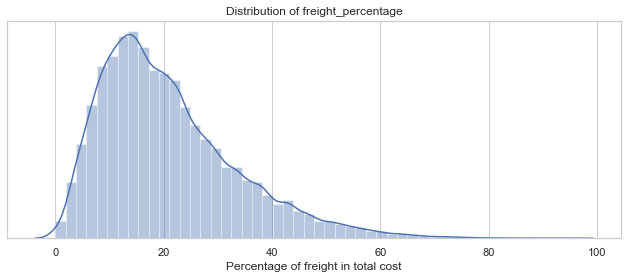

Pourcentage moyen du coût de livraison : 20


In [81]:
# calculer les coûts totaux produits et livraison
df_cart_costs = df_items.groupby(
    'order_id',
    as_index=False).agg({'price': ['sum'],
                         'freight_value': ['sum']})
df_cart_costs.columns = ['order_id',
                         'total_price',
                         'total_freight']
# déterminer la proportion du coût de livraison
df_cart_costs['freight_percentage'] = \
    100 * df_cart_costs['total_freight'] / \
    (df_cart_costs['total_freight'] + df_cart_costs['total_price'])
# afficher la distribution de la proportion du coût de livraison
distribution(df_cart_costs,
             'freight_percentage',
             'Percentage of freight in total cost',
             'dist')
print('Pourcentage moyen du coût de livraison : %d'
      % df_cart_costs['freight_percentage'].mean())

In [82]:
df_cart_costs['freight_percentage_lvl'] = pd.qcut(
    df_cart_costs['freight_percentage'],
    3,
    labels=['Low_FreightCost',
            'Nominal_FreightCost',
            'High_FreightCost'])

In [83]:
pd.qcut(df_cart_costs['freight_percentage'], 3)

0        (13.727, 23.682]
1        (-0.001, 13.727]
2        (-0.001, 13.727]
3        (23.682, 95.545]
4        (-0.001, 13.727]
               ...       
98661    (-0.001, 13.727]
98662    (-0.001, 13.727]
98663    (13.727, 23.682]
98664    (-0.001, 13.727]
98665    (13.727, 23.682]
Name: freight_percentage, Length: 98666, dtype: category
Categories (3, interval[float64]): [(-0.001, 13.727] < (13.727, 23.682] < (23.682, 95.545]]

Text(0.5, 1.02, 'Freight Levels')

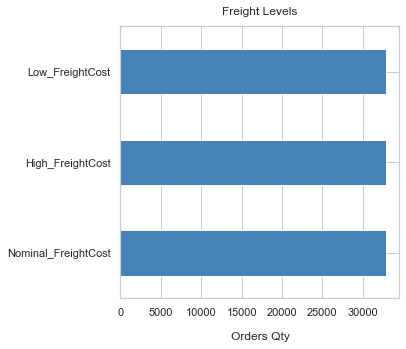

In [84]:
# observer la répartition des commandes par cout de livraison
df_cart_costs['freight_percentage_lvl'].value_counts().plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Orders Qty', labelpad=14)
plt.title('Freight Levels', y=1.02)

In [85]:
# Observer les features créés
df_cart_costs

,order_id,total_price,total_freight,freight_percentage,freight_percentage_lvl
0,00010242fe8c5a6d1ba2dd792cb16214,58.90,13.29,18.409752,Nominal_FreightCost
1,00018f77f2f0320c557190d7a144bdd3,239.90,19.93,7.670400,Low_FreightCost
2,000229ec398224ef6ca0657da4fc703e,199.00,17.87,8.239959,Low_FreightCost
3,00024acbcdf0a6daa1e931b038114c75,12.99,12.79,49.612102,High_FreightCost
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90,18.14,8.319574,Low_FreightCost
...,...,...,...,...,...
98661,fffc94f6ce00a00581880bf54a75a037,299.99,43.41,12.641235,Low_FreightCost
98662,fffcd46ef2263f404302a634eb57f7eb,350.00,36.53,9.450754,Low_FreightCost
98663,fffce4705a9662cd70adb13d4a31832d,99.90,16.95,14.505777,Nominal_FreightCost
98664,fffe18544ffabc95dfada21779c9644f,55.99,8.72,13.475506,Low_FreightCost


In [86]:
# aggréger aux commandes le niveau de coût de livraison
df_orders = df_orders.merge(
    df_cart_costs,
    how='left',
    left_on=['order_id'],
    right_on=['order_id'])

In [87]:
# contrôler le résultat
print(ref-df_orders.shape[0])
df_orders.sample(3)

5019


,order_id,customer_id,order_purchase_timestamp,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_dayofweek,order_purchase_hour,order_purchase_month_label,order_purchase_dayofweek_label,...,effective_delivery_time,delivery_vs_estimated,delivery_vs_estimated_lvl,items_qty,products_qty,most_important_product,total_price,total_freight,freight_percentage,freight_percentage_lvl
56703,270087d97c6abc409514129d62d3a513,d412e4c4402192731f840c6efa07f3b8,2017-08-31 13:43:07,2017,8,31,3,13,Aug,Thu,...,8,10,Nominal_Delivery,single_item,single_product,c7bcab3a7039340cf46705f43bab3ee2,49.0,12.69,20.570595,Nominal_FreightCost
90705,f1d5c2e6867fa93ceee9ef9b34a53cbf,a790343ca6f3fee08112d678b43aa7c5,2018-08-25 21:20:50,2018,8,25,5,21,Aug,Sat,...,3,4,Later_Delivery,single_item,single_product,46fce52cef5caa7cc225a5531c946c8b,2.2,7.39,77.059437,High_FreightCost
85467,d578a6c1bb288c7f9a25b8cfbc3ab962,184cf2d63cab844e956321da06369a1b,2017-06-27 18:13:21,2017,6,27,1,18,Jun,Tue,...,20,9,Nominal_Delivery,single_item,single_product,a85fa7ea0b6ca7f780ad3034bf943070,102.9,29.12,22.057264,Nominal_FreightCost


In [88]:
# créer / actualiser les commandes répartes par année
orders_2017 = df_orders[(df_orders['order_purchase_year'] == 2017) |
                        (df_orders['order_purchase_year'] == 2016)]
orders_2018 = df_orders[(df_orders['order_purchase_year'] == 2018)]

In [89]:
# observer la variation éventuelle entre 2017 et 2018
print('Variation freight_percentage entre 2017 (ref) et 2018 : ' +
      str(round(orders_2017['freight_percentage'].mean() - orders_2018['freight_percentage'].mean())))

Variation freight_percentage entre 2017 (ref) et 2018 : 0


### 5.1.3.  Repérage du type de prix affiché avec terminaison "9", dit "charm price".

In [90]:
# isoler la terminaison "9" des prix affiché, dite "charm price"
# isoler les terminaisons (Centavos, Real)
df_items['last_centavos'] = df_items['price'] % 1
df_items['last_real'] = df_items['price'] % 10 - df_items['price'] % 1
# convertir en info booléen "is_charm"
df_items['charm_centavos'] =\
    df_items['last_centavos'].map(
    lambda x: 0 if x < 0.88 else 1)
df_items['charm_real'] =\
    df_items['last_real'].map(
    lambda x: 0 if x != 9 else 1)
# déterminer un booléen "charm_price" si l'une des terminaisons est "charm"
df_items['charm_price'] = df_items['charm_real'] + df_items['charm_centavos']
df_items['charm_price'] =\
    df_items['charm_price'].map(
    lambda x: 1 if x >= 1 else 0)
# retirer les colonnes obsolètes
Drop = ['last_centavos',
        'last_real',
        'charm_centavos',
        'charm_real']
df_items.drop(Drop, axis=1, inplace=True)

In [91]:
# observer le résultat
df_items.sample(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,charm_price
39023,58ad53486aa4d662036281295465d755,1,d65b6607952f9e0d705b1cbdc92ac027,48436dade18ac8b2bce089ec2a041202,2017-08-14 22:30:19,44.90,16.11,1
49663,70e028766affefb2a0c1dbe2cc075f2a,1,096e14458100c2b6d10f72d69f80cf34,46dc3b2cc0980fb8ec44634e21d2718e,2017-10-08 23:14:16,269.99,24.76,1
62932,8fac4937d08ac74197a48a70c5bc1245,1,fd2168a1a9661512d53cb23d6d23ee02,25e6ffe976bd75618accfe16cefcbd0d,2017-05-09 11:31:07,270.00,17.10,0


In [92]:
# retirer les colonnes inutiles
df_items = df_items.drop(
    columns=['shipping_limit_date',
             'order_item_id'])

In [93]:
# réagencer les colonnes customers
df_items = df_items.rename(columns={
    'freight_value': 'product_freight',
    'price': 'product_price'})

In [94]:
# prix moyens avec ou sans Charm price
df_price_charm = df_items.groupby(
    'charm_price',
    as_index=False).agg({'product_id': ['count'],
                         'product_price': ['mean']})
df_price_charm.columns = ['charm_price',
                          'count',
                          'mean_price']
df_price_charm.set_index('charm_price')

,count,mean_price
charm_price,,
0,33421,132.613027
1,79229,115.608978


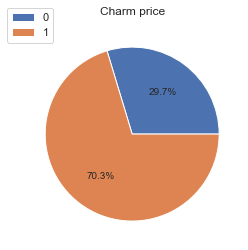

In [95]:
# observer la répartition du charm pricing à travers les produits
plt.title('Charm price', y=1.02)
plt.pie(df_price_charm['count'], autopct='%1.1f%%')
plt.legend(df_price_charm.index, loc='center left', bbox_to_anchor=(-0.1, 1.))

Tandis qu'il y a plus de références en Charm Price, on observe qu'il s'agit en moyenne d'articles moins coûteux, cela reletivisera l'impact du Charm Price sur les ventes.

In [96]:
# dériver un feature purement catégoriel pour le Charm Price
df_items['charmed_price'] =\
    df_items['charm_price'].map(
    lambda x: 'charmed_price' if x == 1 else 'uncharmed_price')

Puisque ce dataset détaille chaque article, on rattachera ces données aux Produits et non aux Commandes.

## 5.2. Products

Ce dataset permet d'accéder aux caractéristiques des produits achetés.

In [97]:
# aperçu des données Products
print(df_products.shape)
df_products.head(3)

(32951, 9)


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0


In [98]:
# retirer les valeurs manquantes et controler la taille résultante
df_products = df_products.dropna().copy()
print(df_products.shape)

(32340, 9)


In [99]:
# renommer les colonnes lenght -> length
df_products = df_products.rename(columns={
    'product_name_lenght': 'product_name_length',
    'product_description_lenght': 'product_description_length'})

### 5.2.1.  Taille de l'article (volume)

In [100]:
# simplifier la taille des produits (volume)
df_products['product_size'] = df_products['product_length_cm'] * \
    df_products['product_height_cm'] * df_products['product_width_cm']
# retirer le détail
df_products = df_products.drop(
    columns=['product_length_cm',
             'product_height_cm',
             'product_width_cm'])

In [101]:
# observer les valeurs numériques
df_products.describe()

,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_size
count,32340.000000,32340.000000,32340.000000,32340.000000,32340.000000
mean,48.476592,771.492393,2.188961,2276.956586,16577.961286
std,10.245699,635.124831,1.736787,4279.291845,27062.978147
min,5.000000,4.000000,1.000000,0.000000,168.000000
25%,42.000000,339.000000,1.000000,300.000000,2880.000000
50%,51.000000,595.000000,1.000000,700.000000,6860.000000
75%,57.000000,972.000000,3.000000,1900.000000,18522.750000
max,76.000000,3992.000000,20.000000,40425.000000,296208.000000


In [102]:
# compter les valeurs manquantes
df_products.isna().sum()

product_id                    0
product_category_name         0
product_name_length           0
product_description_length    0
product_photos_qty            0
product_weight_g              0
product_size                  0
dtype: int64

In [103]:
# retirer les valeurs manquantes
df_products = df_products.dropna().copy()
print(df_products.shape[0])

32340


### 5.2.2.  Catégorisation des produits par type de description : taille de description, de nom, nombre de photos

#### Product Description Length

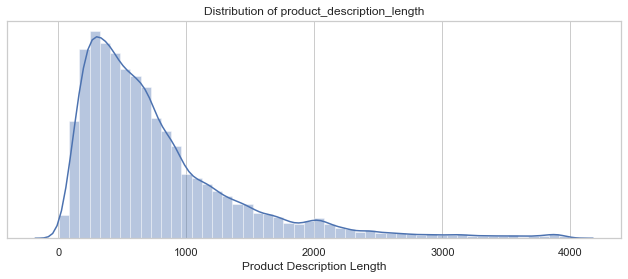

Taille moyenne de la description produit : 771


In [104]:
# observer le product_description_length
distribution(df_products,
             'product_description_length',
             'Product Description Length',
             'dist')
print('Taille moyenne de la description produit : %d'
      % df_products['product_description_length'].mean())

#### Product Name Length

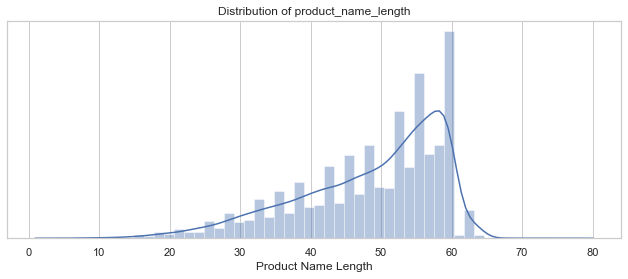

Taille moyenne nom du produit : 48


In [105]:
# observer le taille du nom de produit
distribution(df_products,
             'product_name_length',
             'Product Name Length',
             'dist')
print('Taille moyenne nom du produit : %d'
      % df_products['product_name_length'].mean())

#### Photo Quantity

Text(0.5, 1.02, 'Photos Qty Levels')

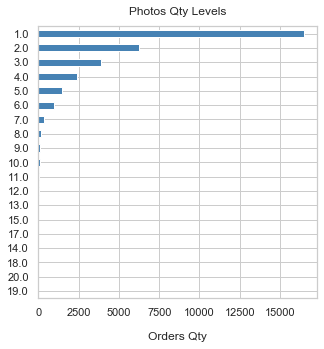

In [106]:
# observer la répartition des nb de photos
df_products['product_photos_qty'].value_counts().plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Orders Qty', labelpad=14)
plt.title('Photos Qty Levels', y=1.02)

In [107]:
# simplifier en aggrégeant au delà de 6 photos
bins = [0, 1, 2, 3, 4, 5, np.inf]
values = [1, 2, 3, 4, 5, 6]
df_products['product_photos_qty'] = pd.cut(df_products['product_photos_qty'], bins, labels=values)

Text(0.5, 1.02, 'Photos Qty Levels')

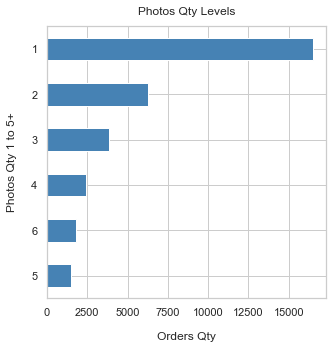

In [108]:
# observer la répartition des nb de photos
df_products['product_photos_qty'].value_counts().plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Orders Qty', labelpad=14)
plt.ylabel('Photos Qty 1 to 5+', labelpad=14)
plt.title('Photos Qty Levels', y=1.02)

### 5.2.3.   Catégorisation des produits par caractéristique taille et poids

#### Taille

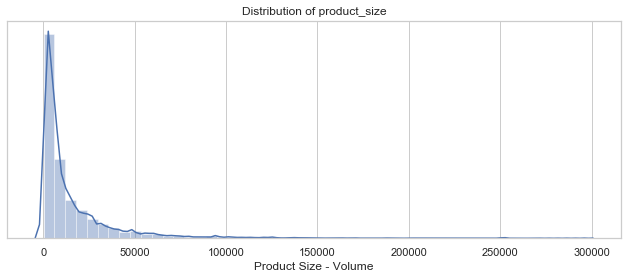

Taille moyenne des produits : 16577


In [109]:
# observer la taille des produits
distribution(df_products,
             'product_size',
             'Product Size - Volume',
             'dist')
print('Taille moyenne des produits : %d'
      % df_products['product_size'].mean())

#### Poids

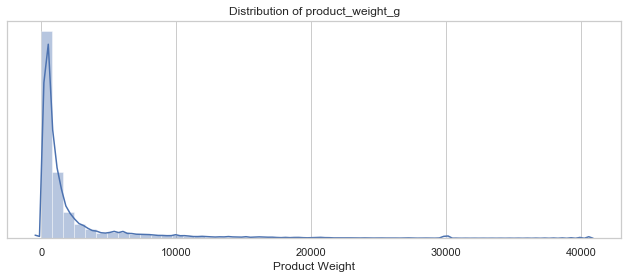

Poids moyen des produits : 2276


In [110]:
# observer le poids
distribution(df_products,
             'product_weight_g',
             'Product Weight',
             'dist')
print('Poids moyen des produits : %d'
      % df_products['product_weight_g'].mean())

In [111]:
df_products.isna().sum()

product_id                    0
product_category_name         0
product_name_length           0
product_description_length    0
product_photos_qty            0
product_weight_g              0
product_size                  0
dtype: int64

#### Catégories de vente des produits

La seule indication qualitative de la nature des articles est contenue dans le nom de sa catégorie de vente. On privilégie la version anglaise pour améliorer la lisibilité.

In [112]:
# exploiter la version anglaise des catégories
df_translation.sample(3)

,product_category_name,product_category_name_english
62,casa_conforto_2,home_comfort_2
25,construcao_ferramentas_construcao,construction_tools_construction
18,eletroportateis,small_appliances


In [113]:
# améliorer la lisibilité des product category
df_translation['product_category_name_english'] =\
    df_translation['product_category_name_english'].str.replace('_', ' ')
df_translation['product_category_name_english'] =\
    df_translation['product_category_name_english'].str.title()

In [114]:
# aggréger aux produits la version anglaise des catégories
df_products = df_products.merge(
    df_translation,
    how='left',
    left_on=['product_category_name'],
    right_on=['product_category_name'])
df_products.sample(3)

,product_id,product_category_name,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_size,product_category_name_english
27003,7b0d4f48315e67c7fe70059533c450f8,ferramentas_jardim,48.0,374.0,1,600.0,2944.0,Garden Tools
17532,e95703a89b7e347a78ac894708191b36,moveis_decoracao,52.0,575.0,1,3100.0,27000.0,Furniture Decor
10563,fde84a599b4b96ce7eef9109caece04b,automotivo,45.0,660.0,1,100.0,600.0,Auto


### 5.2.4.   Rationnalisation des catégories de produits

In [115]:
# décompter et lister les catégories
print(df_products['product_category_name_english'].unique().size)
df_products['product_category_name_english'].unique()

72


array(['Perfumery', 'Art', 'Sports Leisure', 'Baby', 'Housewares',
       'Musical Instruments', 'Cool Stuff', 'Furniture Decor',
       'Home Appliances', 'Toys', 'Bed Bath Table',
       'Construction Tools Safety', 'Computers Accessories',
       'Health Beauty', 'Luggage Accessories', 'Garden Tools',
       'Office Furniture', 'Auto', 'Electronics', 'Fashion Shoes',
       'Telephony', 'Stationery', 'Fashion Bags Accessories', 'Computers',
       'Home Construction', 'Watches Gifts',
       'Construction Tools Construction', 'Pet Shop', 'Small Appliances',
       'Agro Industry And Commerce', 'Furniture Living Room',
       'Signaling And Security', 'Air Conditioning', 'Consoles Games',
       'Books General Interest', 'Costruction Tools Tools',
       'Fashion Underwear Beach', 'Fashion Male Clothing',
       'Kitchen Dining Laundry Garden Furniture',
       'Industry Commerce And Business', 'Fixed Telephony',
       'Construction Tools Lights', 'Books Technical',
       'Home App

In [116]:
# denombrer les produits non catégorisés inconnues
df_products['product_category_name_english'].isna().sum()

13

In [117]:
df_products.isna().sum()

product_id                        0
product_category_name             0
product_name_length               0
product_description_length        0
product_photos_qty                0
product_weight_g                  0
product_size                      0
product_category_name_english    13
dtype: int64

In [118]:
df_products.describe()

,product_name_length,product_description_length,product_weight_g,product_size
count,32340.000000,32340.000000,32340.000000,32340.000000
mean,48.476592,771.492393,2276.956586,16577.961286
std,10.245699,635.124831,4279.291845,27062.978147
min,5.000000,4.000000,0.000000,168.000000
25%,42.000000,339.000000,300.000000,2880.000000
50%,51.000000,595.000000,700.000000,6860.000000
75%,57.000000,972.000000,1900.000000,18522.750000
max,76.000000,3992.000000,40425.000000,296208.000000


#### Effectifs des produits dans chaque catégorie de vente

In [119]:
# calculer la quantité de produits dans chaque catégorie
rows = [[i, df_products[df_products['product_category_name_english'] ==
                        i].shape[0]]
        for i in df_products['product_category_name_english'].unique()]
df_category_qty = pd.DataFrame(rows, columns=['category', 'qty'])
# trier par nb de produits décroissant
df_category_qty = df_category_qty.sort_values(by='qty',
                                              ascending=False)

In [120]:
# top 5 des catégories par nb de produits
df_category_qty[:5]

,category,qty
10,Bed Bath Table,3029
2,Sports Leisure,2867
7,Furniture Decor,2657
13,Health Beauty,2444
4,Housewares,2335


In [121]:
# aggreger aux items les produits
df_items = df_items.merge(
    df_products,
    how='left',
    left_on=['product_id'],
    right_on=['product_id'])
print(df_items.shape[0])
df_items.sample(3)

112650


,order_id,product_id,seller_id,product_price,product_freight,charm_price,charmed_price,product_category_name,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_size,product_category_name_english
72845,5a8cbc60b032f344459aae65f0c01d26,95bc2131ece03edd6623b82c80db02bb,29fe9f200d3fa0c668d2aa1ec7e08dfb,80.0,34.36,0,uncharmed_price,telefonia,55.0,2129.0,1,133.0,1140.0,Telephony
72293,5be47775fbd521b6104cf7ed466afafb,928e52a9ad53a294fdcc91bcf59d1751,955fee9216a65b617aa5c0531780ce60,130.0,11.53,0,uncharmed_price,utilidades_domesticas,34.0,1031.0,6,1600.0,24000.0,Housewares
98726,1facf0f943e2e863012876581d779f16,189898d15ec809a4ca45e1ac2221dea2,897060da8b9a21f655304d50fd935913,35.0,16.11,0,uncharmed_price,informatica_acessorios,26.0,327.0,1,478.0,5040.0,Computers Accessories


#### Quantité de produits vendus dans chaque catégorie de vente

In [122]:
# décompter les produits commandés par catégorie
df_categ_qty = df_items.groupby('product_category_name_english',
                                as_index=False).agg({'order_id': ['count']})
df_categ_qty.columns = ['product_category_name_english',
                        'count']
df_categ_qty = df_categ_qty.sort_values(by='count',
                                        ascending=False)

In [123]:
# top 5 des catégories par décompte des commandes
df_categ_qty[:5]

,product_category_name_english,count
7,Bed Bath Table,11115
43,Health Beauty,9670
65,Sports Leisure,8641
39,Furniture Decor,8334
15,Computers Accessories,7827


In [124]:
# aggreger les décompte de produits et produits commandés
df_category_qty = df_category_qty.merge(
    df_categ_qty,
    how='left',
    left_on=['category'],
    right_on=['product_category_name_english'])
df_category_qty = df_category_qty.sort_values(by='count',
                                              ascending=False)

In [125]:
# afficher les 2 quantités
pd.set_option('display.max_rows', df_category_qty.shape[0]+1)
df_category_qty

,category,qty,product_category_name_english,count
0,Bed Bath Table,3029,Bed Bath Table,11115.0
3,Health Beauty,2444,Health Beauty,9670.0
1,Sports Leisure,2867,Sports Leisure,8641.0
2,Furniture Decor,2657,Furniture Decor,8334.0
6,Computers Accessories,1639,Computers Accessories,7827.0
4,Housewares,2335,Housewares,6964.0
8,Watches Gifts,1329,Watches Gifts,5991.0
9,Telephony,1134,Telephony,4545.0
15,Garden Tools,753,Garden Tools,4347.0
5,Auto,1900,Auto,4235.0


L'ordre des quantités de produits par catégories est similaire à l'ordre des quantités de commandes effectuées dans ces catégories 

In [126]:
# rationaliser les catégories
category_mapping = {
    'Watches Gifts': 'Watches Gifts Toys',
    'Toys': 'Watches Gifts Toys',
    'Food Drink': 'Food Drink & Pets',
    'Food': 'Food Drink & Pets',
    'Drinks': 'Food Drink & Pets',
    'Flowers': 'Food Drink & Pets',
    'Pet Shop': 'Food Drink & Pets',
    'Baby': 'Health Beauty Baby',
    'Health Beauty': 'Health Beauty Baby',
    'Perfumery': 'Health Beauty Baby',
    'Diapers And Hygiene': 'Health Beauty Baby',
    'Bed Bath Table': 'Home Accessories',
    'Home Confort': 'Home Accessories',
    'Home Comfort 2': 'Home Accessories',
    'La Cuisine': 'Home Accessories',
    'Housewares': 'Home Appliances',
    'Small Appliances': 'Home Appliances',
    'Home Appliances 2': 'Home Appliances',
    'Small Appliances Home Oven And Coffee': 'Home Appliances',
    'Air Conditioning': 'Home Appliances',
    'Consoles Games': 'Entertainement',
    'Art': 'Entertainement',
    'Cine Photo': 'Entertainement',
    'Books General Interest': 'Entertainement',
    'Cds Dvds Musicals': 'Entertainement',
    'Music': 'Entertainement',
    'Books Technical': 'Entertainement',
    'Audio': 'Entertainement',
    'Dvds Blu Ray': 'Entertainement',
    'Books Imported': 'Entertainement',
    'Arts And Craftmanship': 'Entertainement',
    'Musical Instruments': 'Entertainement',
    'Fashion Male Clothing': 'Fashion',
    'Fashion Sport': 'Fashion',
    'Fashion Underwear Beach': 'Fashion',
    'Fashion Bags Accessories': 'Fashion',
    'Fashio Female Clothing': 'Fashion',
    'Fashion Shoes': 'Fashion',
    'Fashion Childrens Clothes': 'Fashion',
    'Luggage Accessories': 'Fashion',
    'Kitchen Dining Laundry Garden Furniture': 'Furniture',
    'Furniture Decor': 'Furniture',
    'Office Furniture': 'Furniture',
    'Furniture Living Room': 'Furniture',
    'Furniture Bedroom': 'Furniture',
    'Furniture Mattress And Upholstery': 'Furniture',
    'Costruction Tools Tools': 'Construction & Tools',
    'Construction Tools Safety': 'Construction & Tools',
    'Garden Tools': 'Construction & Tools',
    'Construction Tools Lights': 'Construction & Tools',
    'Construction Tools Construction': 'Construction & Tools',
    'Costruction Tools Garden': 'Construction & Tools',
    'Home Construction': 'Construction & Tools',
    'Computers Accessories': 'Electronics Computers & Accessories',
    'Computers': 'Electronics Computers & Accessories',
    'Fixed Telephony': 'Telephony',
    'Tablets Printing Image': 'Electronics Computers & Accessories',
    'Electronics': 'Electronics Computers & Accessories',
    'Agro Industry And Commerce': 'Corporate',
    'Signaling And Security': 'Corporate',
    'Security And Services': 'Corporate',
    'Industry Commerce And Business': 'Corporate',
    'Market Place': 'Corporate',
    'Stationery': 'Supplies',
    'Cool Stuff': 'Supplies',
    'Party Supplies': 'Supplies',
    'Christmas Supplies': 'Supplies'}

In [127]:
# renommer le feature des regroupement de catégories
df_category_qty = df_category_qty.rename(columns={'product_category_name_english': 'rational_category'})

In [128]:
# vérifier l'application de la correspondance
df_category_qty['rational_category'] = df_category_qty['rational_category'].replace(category_mapping)

In [129]:
# décompter les produits référencés par rational_category
df_rat_categ_qty_ref = df_category_qty.groupby(
    'rational_category',
    as_index=False).agg({'qty': ['sum']})
df_rat_categ_qty_ref.columns = ['rational_category',
                                'new_qty']
df_rat_categ_qty_ref = df_rat_categ_qty_ref.sort_values(by='new_qty',
                                                        ascending=False)

[Text(0, 0.5, 'Categories'),
 Text(0.5, 0, 'Products Qty'),
 Text(0.5, 1.0, 'Products by Category')]

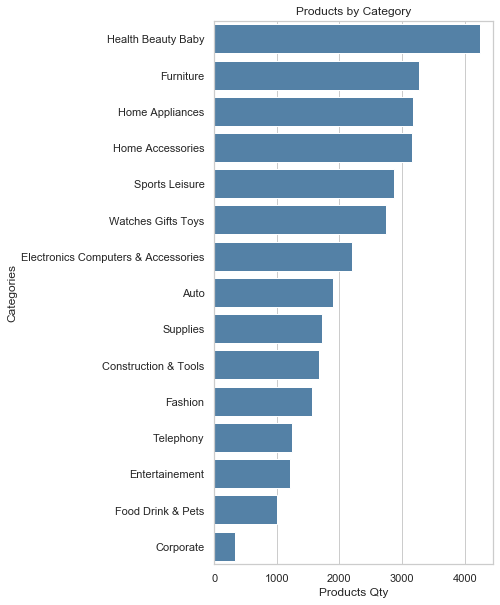

In [130]:
# contrôler la nouvelle répartition des produits référencés
fig, ax = plt.subplots(figsize=(5, 10))
ax = sns.barplot(y='rational_category',
                 x='new_qty',
                 color='Steelblue',
                 data=df_rat_categ_qty_ref)
ax.set(xlabel='Products Qty',
       ylabel='Categories',
       title='Products by Category')

In [131]:
# décompter les produits commandés par rational_category
df_rat_categ_qty = df_category_qty.groupby(
    'rational_category',
    as_index=False).agg({'count': ['sum']})
df_rat_categ_qty.columns = ['rational_category',
                            'new_count']
df_rat_categ_qty = df_rat_categ_qty.sort_values(by='new_count',
                                                ascending=False)

[Text(0, 0.5, 'Categories'),
 Text(0.5, 0, 'Orders Qty'),
 Text(0.5, 1.0, 'Orders by Category')]

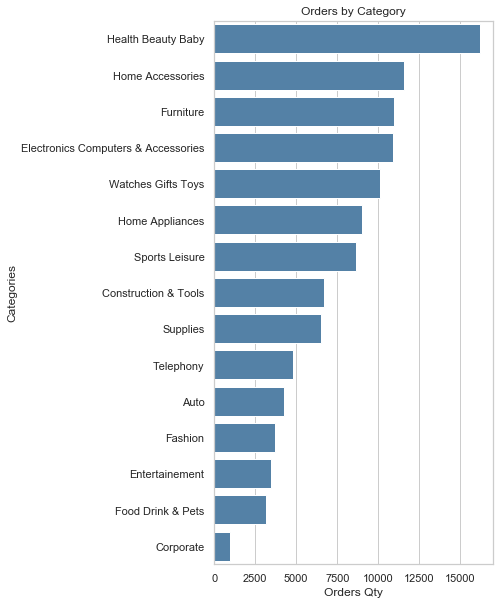

In [132]:
# contrôler la nouvelle répartition par regroupement de catégories
fig, ax = plt.subplots(figsize=(5, 10))
ax = sns.barplot(y='rational_category',
                 x='new_count',
                 color='Steelblue',
                 data=df_rat_categ_qty)
ax.set(xlabel='Orders Qty',
       ylabel='Categories',
       title='Orders by Category')

In [133]:
# renommer le feature des regroupement de catégories
df_items = df_items.rename(
    columns={'product_category_name_english': 'rational_category'})

# appliquer la correspondance sur le dataset des produits
df_items['rational_category'] =\
    df_items['rational_category'].replace(category_mapping)

# retirer l'ancienne colonne product_category_name
df_items = df_items.drop(
    columns=['product_category_name'])

In [134]:
df_items.sample(3)

,order_id,product_id,seller_id,product_price,product_freight,charm_price,charmed_price,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_size,rational_category
65653,6ace9f71dee0013cc1f49942b5279b0c,c6e513054b982283c1cbbb2a45d02d83,f8db351d8c4c4c22c6835c19a46f01b0,22.90,11.85,1,charmed_price,56.0,777.0,5,300.0,1512.0,Supplies
41758,a1b80d424c933786ee29fa4759d028cd,be0dbdc3d67d55727a65d4cd696ca73c,3340ef1913fb70d28420f6ceb685c339,64.99,16.15,1,charmed_price,47.0,493.0,1,245.0,3724.0,Electronics Computers & Accessories
99566,1db209fdc128d35605e562a70180dd32,0d98754cfefd5a306f6633725f3aed59,4c8b8048e33af2bf94f2eb547746a916,101.20,21.35,0,uncharmed_price,59.0,186.0,1,11150.0,30780.0,Home Accessories


In [135]:
df_items[df_items['product_id'] == 'ceb43e52119b25c8f2b6049a5534c339']

,order_id,product_id,seller_id,product_price,product_freight,charm_price,charmed_price,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_size,rational_category
21403,cf2159bbc127ae7a92a057266d687260,ceb43e52119b25c8f2b6049a5534c339,6b243f80ed07b10f0e8aa0f21a205f3c,64.9,16.42,1,charmed_price,55.0,1392.0,1,750.0,4096.0,Sports Leisure
60975,7585d4e21b02da91dd6b9dae232f96f8,ceb43e52119b25c8f2b6049a5534c339,6b243f80ed07b10f0e8aa0f21a205f3c,64.9,15.21,1,charmed_price,55.0,1392.0,1,750.0,4096.0,Sports Leisure
84799,3f60c18dceaa348eb8891eea71a53dc1,ceb43e52119b25c8f2b6049a5534c339,6b243f80ed07b10f0e8aa0f21a205f3c,64.9,23.60,1,charmed_price,55.0,1392.0,1,750.0,4096.0,Sports Leisure
85688,3d5651800efaa81c9c96808ded6f145e,ceb43e52119b25c8f2b6049a5534c339,6b243f80ed07b10f0e8aa0f21a205f3c,64.9,15.21,1,charmed_price,55.0,1392.0,1,750.0,4096.0,Sports Leisure


In [136]:
df_items.shape[0]

112650

In [137]:
# calculer la quantité de produits référencés dans chaque nouvelle catégorie
rows = [[i, df_products[df_products['product_category_name_english'] ==
                        i].shape[0]]
        for i in df_products['product_category_name_english'].unique()]
df_category_qty = pd.DataFrame(rows, columns=['category', 'qty'])
# trier par nb de produits décroissant
df_category_qty = df_category_qty.sort_values(by='qty',
                                              ascending=False)

## 5.3. Simplification au produit le plus cher d'une commande

La stratégie est d'aggréger les informations produits aux commandes sur le produit "phare" most_important_product

In [138]:
print(ref-df_orders.shape[0])
df_orders.sample(3)

5019


,order_id,customer_id,order_purchase_timestamp,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_dayofweek,order_purchase_hour,order_purchase_month_label,order_purchase_dayofweek_label,...,effective_delivery_time,delivery_vs_estimated,delivery_vs_estimated_lvl,items_qty,products_qty,most_important_product,total_price,total_freight,freight_percentage,freight_percentage_lvl
9503,b98c5a8bd8fcbb53d6d1189d07279780,624aca1ca85903e1ddc3f825552925d1,2018-03-25 10:50:20,2018,3,25,6,10,Mar,Sun,...,20,-2,Later_Delivery,single_item,single_product,10070e29929f7c7d609ee3201f236b8e,95.20,16.64,14.878398,Nominal_FreightCost
15042,108e1d5b7a25ff07b49e500b1c7ae4b0,7d1fee2758dd8420cb44dc7f4fdec08f,2017-06-07 10:57:08,2017,6,7,2,10,Jun,Wed,...,14,18,Sooner_Delivery,single_item,single_product,cb6c1c21ebc9c153a7baf319c515657a,31.90,34.15,51.703255,High_FreightCost
25163,763cef494955df156986e220c7810b18,d8c1539abb37e4d303c460e0329954d5,2018-07-04 19:09:55,2018,7,4,2,19,Jul,Wed,...,2,18,Sooner_Delivery,single_item,single_product,81a266bbf4c7aa3113db84e81ca899b8,99.99,15.01,13.052174,Low_FreightCost


In [139]:
df_orders['most_important_product'].unique().size

30603

In [140]:
df_orders.shape[0]

94422

In [141]:
df_orders[df_orders['most_important_product'] == 'ceb43e52119b25c8f2b6049a5534c339']

,order_id,customer_id,order_purchase_timestamp,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_dayofweek,order_purchase_hour,order_purchase_month_label,order_purchase_dayofweek_label,...,effective_delivery_time,delivery_vs_estimated,delivery_vs_estimated_lvl,items_qty,products_qty,most_important_product,total_price,total_freight,freight_percentage,freight_percentage_lvl
3022,cf2159bbc127ae7a92a057266d687260,79986e17c3a038cb24355365fc78a0e9,2018-04-13 07:50:12,2018,4,13,4,7,Apr,Fri,...,6,21,Sooner_Delivery,single_item,single_product,ceb43e52119b25c8f2b6049a5534c339,64.9,16.42,20.191835,Nominal_FreightCost
8927,3d5651800efaa81c9c96808ded6f145e,2a882786bc3a3af530ed3405b171b09b,2017-09-16 19:36:06,2017,9,16,5,19,Sep,Sat,...,5,12,Nominal_Delivery,single_item,single_product,ceb43e52119b25c8f2b6049a5534c339,64.9,15.21,18.986394,Nominal_FreightCost
18856,7585d4e21b02da91dd6b9dae232f96f8,d106918f73f119d9ebf155a753135f40,2017-10-19 22:15:23,2017,10,19,3,22,Oct,Thu,...,5,13,Nominal_Delivery,single_item,single_product,ceb43e52119b25c8f2b6049a5534c339,64.9,15.21,18.986394,Nominal_FreightCost
74870,3f60c18dceaa348eb8891eea71a53dc1,7b0e5d9d1949bce0504d928d8897dead,2018-08-01 20:48:00,2018,8,1,2,20,Aug,Wed,...,7,12,Nominal_Delivery,single_item,single_product,ceb43e52119b25c8f2b6049a5534c339,64.9,23.60,26.666667,High_FreightCost


In [142]:
df_items.shape

(112650, 13)

In [143]:
# aggréger aux commandes les informations détaillées des produits
df_orders = df_orders.merge(
    df_items,
    how='left',
    left_on=['order_id',
             'most_important_product'],
    right_on=['order_id',
              'product_id'])
print(ref-df_orders.shape[0])
df_orders.sample(3)


-4286


,order_id,customer_id,order_purchase_timestamp,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_dayofweek,order_purchase_hour,order_purchase_month_label,order_purchase_dayofweek_label,...,product_price,product_freight,charm_price,charmed_price,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_size,rational_category
102735,f2afcdfbf3e9be7b7561ccd2a7e4a9cc,cf0f612ef30da1ff2dfe1bc7b409d20d,2017-07-30 22:29:00,2017,7,30,6,22,Jul,Sun,...,74.90,8.56,1,charmed_price,56.0,976.0,4,400.0,3750.0,Furniture
44612,186f042cdce95c754951633686eb1dc5,50875d83ed44bbf8b61776a85aadbc65,2017-03-20 22:56:13,2017,3,20,0,22,Mar,Mon,...,34.90,16.05,1,charmed_price,60.0,1251.0,2,800.0,9000.0,Construction & Tools
924,9370fc845feb5045400765a17c075cae,d020628b224f6a7738f735fa3f648cfa,2018-02-07 08:04:29,2018,2,7,2,8,Feb,Wed,...,65.99,16.71,1,charmed_price,33.0,910.0,1,700.0,15750.0,Supplies


In [144]:
# retirer les valeurs manquantes et controler la taille résultante
df_orders = df_orders.dropna().copy()
print(df_orders.shape)

(102232, 36)


In [145]:
df_orders.columns

Index(['order_id', 'customer_id', 'order_purchase_timestamp',
       'order_purchase_year', 'order_purchase_month', 'order_purchase_day',
       'order_purchase_dayofweek', 'order_purchase_hour',
       'order_purchase_month_label', 'order_purchase_dayofweek_label',
       'time_zone_hour', 'time_zone_day', 'purchase_time_zone',
       'estimated_delivery_time', 'effective_delivery_time',
       'delivery_vs_estimated', 'delivery_vs_estimated_lvl', 'items_qty',
       'products_qty', 'most_important_product', 'total_price',
       'total_freight', 'freight_percentage', 'freight_percentage_lvl',
       'product_id', 'seller_id', 'product_price', 'product_freight',
       'charm_price', 'charmed_price', 'product_name_length',
       'product_description_length', 'product_photos_qty', 'product_weight_g',
       'product_size', 'rational_category'],
      dtype='object')

# 6. Paiements

Un client peut choisir de payer à l'aide de plusieurs payment_type ce qui ouvre un payment_sequential >1. <br/> 
Il peut également choisir un étalement en n fois (valeur de payment_installments) dans le cas d'un paiement par carte de crédit.

In [146]:
# montrer un aperçu des données de paiement
df_payments.sample(3)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
65896,8b56c0315e44af9a56cef82dce0aa443,1,credit_card,2,138.73
47298,7a2a2633b023ac3ee1dc583d44181b2a,1,credit_card,5,88.61
83925,9e1516d69461cbce6204729191230717,1,boleto,1,156.33


In [147]:
df_payments.isna().sum()

order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

## 6.1. Type de Paiement

In [148]:
# lister les type de paiement
df_payments['payment_type'].unique()

array(['credit_card', 'boleto', 'voucher', 'debit_card', 'not_defined'],
      dtype=object)

In [149]:
df_payments['payment_type'].value_counts()

credit_card    76795
boleto         19784
voucher         5775
debit_card      1529
not_defined        3
Name: payment_type, dtype: int64

In [150]:
# identifier les types non définis
cols = ['payment_sequential',
        'payment_type',
        'payment_installments',
        'payment_value']
mask = (df_payments['payment_type'] == 'not_defined')
print(df_payments[cols][mask].shape)
df_payments[cols][mask].sample(3)

(3, 4)


,payment_sequential,payment_type,payment_installments,payment_value
51280,1,not_defined,1,0.0
57411,1,not_defined,1,0.0
94427,1,not_defined,1,0.0


In [151]:
# retirer les paiements indéfinis
df_payments = df_payments[df_payments['payment_type'] != 'not_defined']
print(df_payments.shape)

(103883, 5)


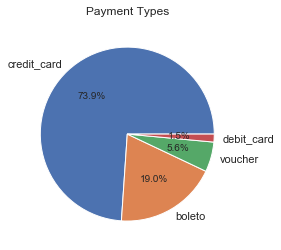

In [152]:
# observer la répartition des types de payment
plt.title('Payment Types', y=1.02)
plt.pie(df_payments['payment_type'].value_counts(),
        labels=df_payments['payment_type'].value_counts().index,
        autopct='%1.1f%%')
plt.show()

In [153]:
# ordonner les paiements par valeur décroissante
df_payments = df_payments.sort_values(by=['order_id', 'payment_value'],
                                      ascending=False)

# retenir la taille de la séquence de paiement
df_payments_details = df_payments.groupby(
    'order_id',
    as_index=False).agg({'payment_sequential': 'max',
                         'payment_installments': 'max',
                         'payment_value': 'sum'})
df_payments_details.columns = ['order_id',
                               'payment_sequence_size',
                               'payment_installments_size',
                               'payment_total']

# aggreger les détails
df_payments = df_payments.merge(
    df_payments_details,
    how='left',
    left_on=['order_id'],
    right_on=['order_id'])

# vérifier le résultat
df_payments.sample(3)

,order_id,payment_sequential,payment_type,payment_installments,payment_value,payment_sequence_size,payment_installments_size,payment_total
4258,f5979d5f4e85e073bf3cdd17e94c79d0,1,credit_card,5,354.62,1,5,354.62
58369,6fc237eec099504ef31e3f3896596be7,1,boleto,1,43.41,1,1,43.41
62900,64c62ba0c1c347994fbc56da00ce2dae,1,credit_card,8,176.88,1,8,176.88


In [154]:
# retirer les doublons en gardant le paiement le plus important
df_payments.drop_duplicates(subset='order_id', keep='first', inplace=True)

In [155]:
# renommer les colonnes
df_payments = df_payments.rename(columns={
    'payment_type': 'main_payment_type',
    'payment_value': 'main_payment_value'})
# retirer les colonnes obsolètes
df_payments = df_payments.drop(
    columns=['payment_sequential',
             'payment_installments'])

In [156]:
# vérfier le résultat
df_payments.sample(3)

,order_id,main_payment_type,main_payment_value,payment_sequence_size,payment_installments_size,payment_total
74039,49379667c1feebaf34be9e13b01210b9,voucher,47.19,1,1,47.19
22469,c8a93f34ce6f1d3299b0e762f62dfc3d,credit_card,162.49,1,8,162.49
69165,553379bf1f6c95489ae135f97327fd91,voucher,119.13,1,1,119.13


In [157]:
# contrôler les valeurs manquantes
df_payments.isna().sum()

order_id                     0
main_payment_type            0
main_payment_value           0
payment_sequence_size        0
payment_installments_size    0
payment_total                0
dtype: int64

In [158]:
# dériver un feature réduits à 2 moyens de paiement
df_payments['main_payment_type_cat'] =\
    df_payments['main_payment_type'].map(
    lambda x: 'Credit_Card_PayType' if x == 'credit_card' else 'Other_PayType')

In [159]:
# aggreger les paiements à la commande
df_orders = df_orders.merge(
    df_payments,
    how='left',
    left_on=['order_id'],
    right_on=['order_id'])

In [160]:
# retirer les valeurs manquantes et controler la taille résultante
df_orders = df_orders.dropna().copy()
print(df_orders.shape)

(102232, 42)


## 6.2. Ventes par catégorie de produit 

[Text(0, 0.5, 'Products Categories'),
 Text(0.5, 0, 'Sales Revenue'),
 Text(0.5, 1.0, 'Sales by Category')]

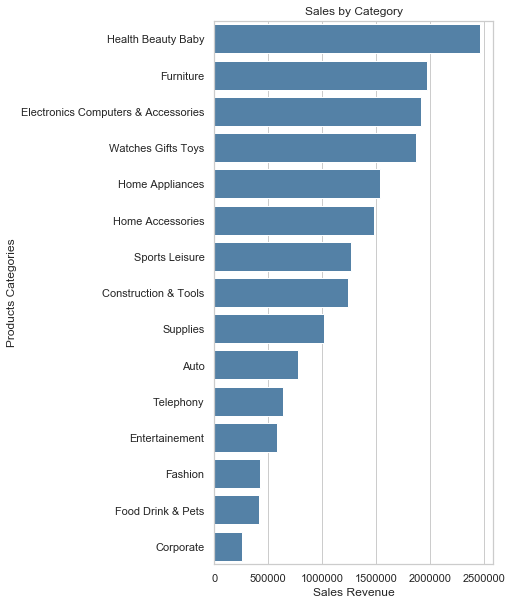

In [161]:
# répartition des ventes par catégorie de produit
df_sales_categ = df_orders.groupby(
    'rational_category',
    as_index=False).agg({'payment_total': ['sum']})
df_sales_categ.columns = ['rational_category',
                          'sales']
df_sales_categ = df_sales_categ.sort_values(by=['sales'],
                                            ascending=False)
fig, ax = plt.subplots(figsize=(5, 10))
ax = sns.barplot(y='rational_category',
                 x='sales',
                 color='Steelblue',
                 data=df_sales_categ)
ax.set(xlabel='Sales Revenue',
       ylabel='Products Categories',
       title='Sales by Category')

In [162]:
# répartition des ventes en fonction du Charm price
df_sales_charm = df_orders.groupby(
    'charm_price',
    as_index=False).agg({'payment_total': ['sum'],
                        'order_id': ['count']})
df_sales_charm.columns = ['charm_price',
                          'sales',
                          'qty']
df_sales_charm['avg_sale'] = df_sales_charm['sales'] / df_sales_charm['qty']
df_sales_charm = df_sales_charm.sort_values(by=['avg_sale'],
                                            ascending=False)
df_sales_charm

,charm_price,sales,qty,avg_sale
0,0,6.005678e+06,30357,197.835018
1,1,1.182910e+07,71875,164.578752


Le revenu généré par les articles Charm Price n'est que le double de celui sans Charm Price, cependant qu'il sont plus de 2 fois plus souvent achetés : cela conduit à un revenu moyen des articles en Charm Price inférieur de 20% à celui des autres articles.

## 6.3. Evolution mensuelle des ventes

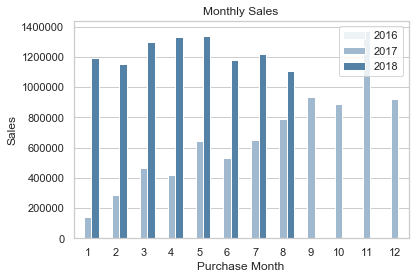

In [163]:
# évolution mensuelle des ventes
df_sales_month = df_orders.groupby(
    ['order_purchase_year', 'order_purchase_month'],
    as_index=False).agg({'payment_total': ['sum']})
df_sales_month.columns = ['order_purchase_year',
                          'order_purchase_month',
                          'sales']
ax = sns.barplot(x='order_purchase_month',
                 y='sales',
                 hue='order_purchase_year',
                 color='Steelblue',
                 data=df_sales_month)
ax.set(xlabel='Purchase Month',
       ylabel='Sales',
       title='Monthly Sales')
plt.legend(loc='upper right')

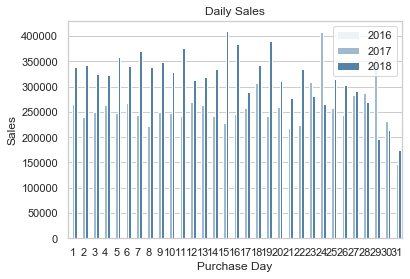

In [164]:
# évolution des ventes au cours du mois
df_sales_day = df_orders.groupby(
    ['order_purchase_year', 'order_purchase_day'],
    as_index=False).agg({'payment_total': ['sum']})
df_sales_day.columns = ['order_purchase_year',
                        'order_purchase_day',
                        'sales']
ax = sns.barplot(x='order_purchase_day',
                 y='sales',
                 hue='order_purchase_year',
                 color='Steelblue',
                 data=df_sales_day)
ax.set(xlabel='Purchase Day',
       ylabel='Sales',
       title='Daily Sales')
plt.legend(loc='upper right')

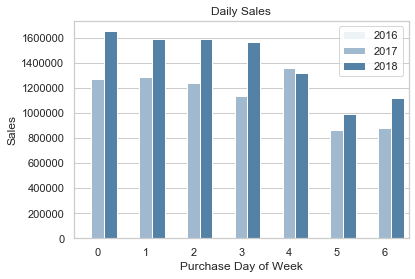

In [165]:
# évolution des ventes au cours de la semaine
df_sales_dayofweek = df_orders.groupby(
    ['order_purchase_year', 'order_purchase_dayofweek'],
    as_index=False).agg({'payment_total': ['sum']})
df_sales_dayofweek.columns = ['order_purchase_year',
                              'order_purchase_dayofweek',
                              'sales']
ax = sns.barplot(x='order_purchase_dayofweek',
                 y='sales',
                 hue='order_purchase_year',
                 color='Steelblue',
                 data=df_sales_dayofweek)
ax.set(xlabel='Purchase Day of Week',
       ylabel='Sales',
       title='Daily Sales')
plt.legend(loc='upper right')

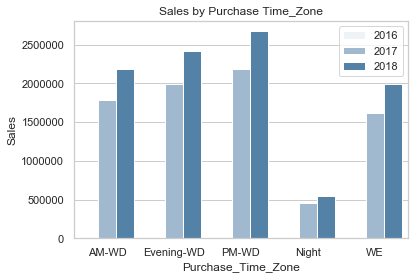

In [166]:
# niveau des ventes par purchase_time_zone
df_sales_time_zone = df_orders.groupby(
    ['order_purchase_year', 'purchase_time_zone'],
    as_index=False).agg({'payment_total': ['sum']})
df_sales_time_zone.columns = ['order_purchase_year',
                              'purchase_time_zone',
                              'sales']
ax = sns.barplot(x='purchase_time_zone',
                 y='sales',
                 hue='order_purchase_year',
                 color='Steelblue',
                 data=df_sales_time_zone)
ax.set(xlabel='Purchase_Time_Zone',
       ylabel='Sales',
       title='Sales by Purchase Time_Zone')
plt.legend(loc='upper right')

## 6.4 Niveaux de paiements

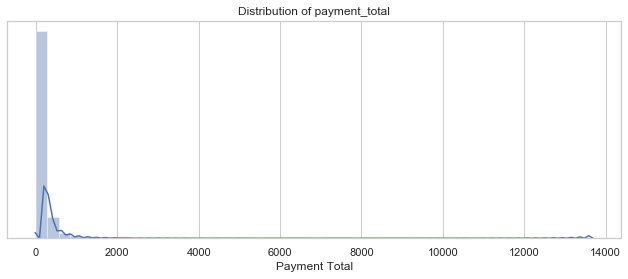

Paiements moyens  : 174


In [167]:
# observer les valeurs de paiements
distribution(df_orders,
             'payment_total',
             'Payment Total',
             'dist')
print('Paiements moyens  : %d'
      % df_orders['payment_total'].mean())

In [168]:
# fonction de transformation des features numériques


def rankgauss(data, feature):
    # crée une instance de quatiletransformer
    transformer = QuantileTransformer(n_quantiles=100,
                                      random_state=1111,
                                      output_distribution='normal')
    # adpate au feature
    transformer.fit(data[[feature]])
    # préfixe le nouveau feature
    newfeat = str('N_RG_' + feature)
    # ajoute le nouveau feature transformé
    data[newfeat] = transformer.transform(data[[feature]])
    # retire le feature dans sa version d'origine
    # data.drop(feature, axis=1, inplace=True)
    # retourne le nouveau dataframe
    return data

In [169]:
# fonction de transformation des features numériques


def simple_scale(data, feature):
    # crée une instance de quatiletransformer
    transformer = StandardScaler()
    # adpate au feature
    transformer.fit(data[[feature]])
    # préfixe le nouveau feature
    newfeat = str('N_SCALE_' + feature)
    # ajoute le nouveau feature transformé
    data[newfeat] = transformer.transform(data[[feature]])
    # retire le feature dans sa version d'origine
    # data.drop(feature, axis=1, inplace=True)
    # retourne le nouveau dataframe
    return data

In [170]:
simple_scale(df_orders,
             'payment_total')

,order_id,customer_id,order_purchase_timestamp,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_dayofweek,order_purchase_hour,order_purchase_month_label,order_purchase_dayofweek_label,...,product_weight_g,product_size,rational_category,main_payment_type,main_payment_value,payment_sequence_size,payment_installments_size,payment_total,main_payment_type_cat,N_SCALE_payment_total
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017,10,2,0,10,Oct,Mon,...,500.0,1976.0,Home Appliances,voucher,18.59,3,1,38.71,Other_PayType,-0.502877
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,2018,7,24,1,20,Jul,Tue,...,400.0,4693.0,Health Beauty Baby,boleto,141.46,1,1,141.46,Other_PayType,-0.122229
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,2018,8,8,2,8,Aug,Wed,...,420.0,9576.0,Auto,credit_card,179.12,1,3,179.12,Credit_Card_PayType,0.017286
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,2017,11,18,5,19,Nov,Sat,...,450.0,6000.0,Food Drink & Pets,credit_card,72.20,1,1,72.20,Credit_Card_PayType,-0.378810
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,2018,2,13,1,21,Feb,Tue,...,250.0,11475.0,Supplies,credit_card,28.62,1,1,28.62,Credit_Card_PayType,-0.540257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102227,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,2018-02-06 12:58:58,2018,2,6,1,12,Feb,Tue,...,4950.0,16000.0,Health Beauty Baby,credit_card,195.00,1,3,195.00,Credit_Card_PayType,0.076115
102228,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,2017-08-27 14:46:43,2017,8,27,6,14,Aug,Sun,...,13300.0,63360.0,Home Appliances,credit_card,271.01,1,5,271.01,Credit_Card_PayType,0.357702
102229,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,2018-01-08 21:28:27,2018,1,8,0,21,Jan,Mon,...,6550.0,8000.0,Electronics Computers & Accessories,credit_card,441.16,1,4,441.16,Credit_Card_PayType,0.988040
102230,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,2018-01-08 21:28:27,2018,1,8,0,21,Jan,Mon,...,6550.0,8000.0,Electronics Computers & Accessories,credit_card,441.16,1,4,441.16,Credit_Card_PayType,0.988040


In [171]:
df_orders['eq_payment_lvl'] = pd.qcut(
    df_orders['payment_total'],
    4,
    labels=['Light_Payment',
            'UnderMed_Payment',
            'OverMed_Payment',
            'Heavy_Payment'])

Text(0.5, 1.02, 'Payment Levels')

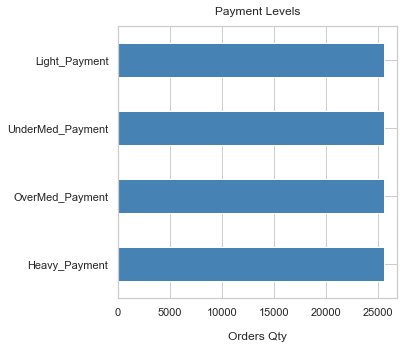

In [172]:
# observer la répartition des niveaux de payment
df_orders['eq_payment_lvl'].value_counts(sort=False).plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Orders Qty', labelpad=14)
plt.title('Payment Levels', y=1.02)

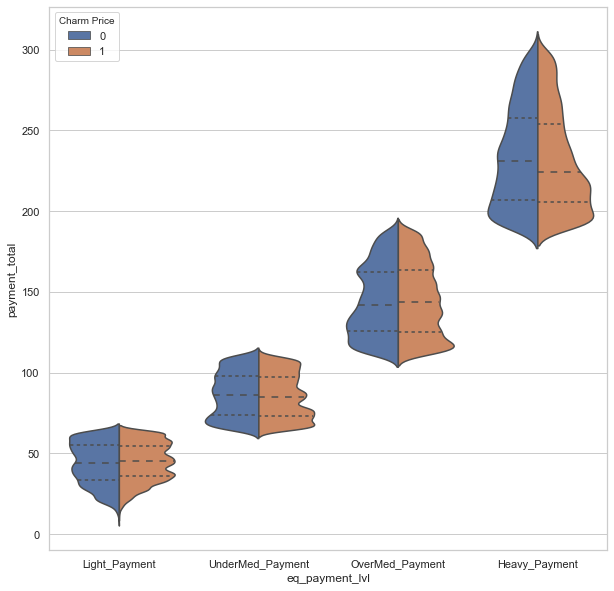

In [173]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.violinplot(x='eq_payment_lvl',
                    y='payment_total',
                    hue='charm_price',
                    data=df_orders[(df_orders['payment_total'] < 300)],
                    split=True,
                    inner='quartile')
plt.legend(title='Charm Price', loc='upper left')

Ce type d'investigation permet de nuancer l'intérêt du Charm Price, qui dans ce cas a une efficacité variable selon la plage de dépense. Les prix élevés ne sont pas en Charm Price, les effets de seuils doivent être pris en compte, car selon le cas les dépenses sont plus ou moins élevées.

# 7. Données géographiques

Geolocation détaille toutes les paires {lat, lng}, associée à un zip_code_prefix, avec toute une diversité pour chaque {city, state}.
Pour conserver une exploitabilité et une signification marketing (zone géographiques, distances, etc.) on propose de préserver une donnée de localisation simple {lat mean, lng mean} qui sera associé à chaque ville {city, state}. <br/>
Pour dériver une distance entre le client et le vendeur, on propose de conserver les données précises.

In [174]:
# aperçu des données geolocation
df_geolocation.sample(3)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
650599,38500,-18.610286,-47.604855,monte carmelo,MG
234167,9660,-23.657833,-46.595993,são bernardo do campo,SP
100164,4671,-23.657111,-46.691504,sao paulo,SP


In [175]:
df_geolocation.isna().sum()

geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype: int64

In [176]:
# aperçu des données géographiques pour customers
df_customers.sample(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_count
615,8a83cd2272d6fb105959b4385ff872ec,6bb68e803ab5d836c7bdb0c3d3281953,21240,rio de janeiro,RJ,1
31185,723409d11424a9f6ea00c73150a9ee1c,b6d926fdda95c5c475fe48cfd35435d9,59162,sao jose de mipibu,RN,1
61063,9a91fdf882a557e2fcbf6d64ad100d94,73630b166ec1457c896290ec9ffaee6a,20040,rio de janeiro,RJ,1


In [177]:
df_customers.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
order_count                 0
dtype: int64

In [178]:
# aperçu des données géographiques pour sellers
df_sellers.sample(3)

,seller_id,seller_zip_code_prefix,seller_city,seller_state
1644,c13ef0cfbe42f190780f621ce81f2234,1207,sao paulo sp,SP
111,3f9be91358837bff69df67edfa3e42e8,86039,londrina,PR
1801,8a130737016f838139d31878787a39c9,3187,sao paulo,SP


In [179]:
df_sellers.isna().sum()

seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

## 7.1. Rationalisation des données géographiques

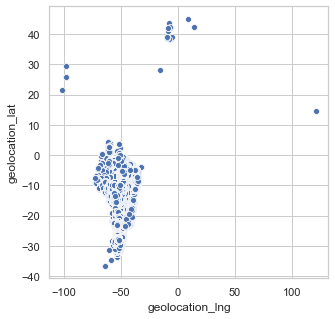

In [180]:
# afficher la répartion des localisations détaillées
fig, ax = plt.subplots(figsize=(5, 5))
ax = sns.scatterplot(x='geolocation_lng',
                     y='geolocation_lat',
                     data=df_geolocation)

In [181]:
# identifier les localisations hors Brésil
cols = ['geolocation_city',
        'geolocation_state',
        'geolocation_lat',
        'geolocation_lng']
mask = (df_geolocation['geolocation_lat'] > 10)
print(df_geolocation[cols][mask].shape)
df_geolocation[cols][mask].sample(7)

(26, 4)


,geolocation_city,geolocation_state,geolocation_lat,geolocation_lng
585260,santana do paraiso,MG,25.995245,-98.078533
860562,ilha dos valadares,PR,42.184003,-8.723762
865611,areia branca dos assis,PR,39.057629,-9.400037
769391,porto trombetas,PA,42.167251,-6.898559
769489,porto trombetas,PA,42.167251,-6.898559
822529,varzea grande,MT,38.816816,-9.394625
387565,bom retiro da esperanca,SP,28.008978,-15.536867


In [182]:
# retirer les localisations marginales
df_geolocation = df_geolocation[df_geolocation['geolocation_lat'] < 10].copy()

In [183]:
# normaliser les noms de ville, et effet de la normalisation
print('geoloc cities : '
      + str(df_geolocation['geolocation_city'].unique().size))
df_geolocation['geolocation_city'] = df_geolocation['geolocation_city'].str\
    .normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
print('geoloc cities norm : '
      + str(df_geolocation['geolocation_city'].unique().size))
print('customers cities : '
      + str(df_customers['customer_city'].unique().size))
df_customers['customer_city'] = df_customers['customer_city'].str\
    .normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
print('customers cities norm : '
      + str(df_customers['customer_city'].unique().size))
print('sellers cities : '
      + str(df_sellers['seller_city'].unique().size))
df_sellers['seller_city'] = df_sellers['seller_city'].str\
    .normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
print('sellers cities norm : '
      + str(df_sellers['seller_city'].unique().size))
# améliorer la lisibilité en écriture type "title"
df_customers['customer_city'] = df_customers['customer_city'].str.title()
df_sellers['seller_city'] = df_sellers['seller_city'].str.title()
df_geolocation['geolocation_city'] = df_geolocation['geolocation_city'].str.title()

geoloc cities : 8007
geoloc cities norm : 5965
customers cities : 4119
customers cities norm : 4119
sellers cities : 611
sellers cities norm : 609


In [184]:
# simplifier par une latitude unique {ville, état}
df_geolocation['unique_geolocation_lat'] = df_geolocation.groupby(
    ['geolocation_city',
     'geolocation_state']
)['geolocation_lat'].transform(lambda x: x.mean())

In [185]:
# simplifier par une longitude unique {ville, état}
df_geolocation['unique_geolocation_lng'] = df_geolocation.groupby(
    ['geolocation_city',
     'geolocation_state']
)['geolocation_lng'].transform(lambda x: x.mean())

In [186]:
# observer le résultat des traitements
df_geolocation.sample(3)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,unique_geolocation_lat,unique_geolocation_lng
731375,58200,-6.849318,-35.485817,Guarabira,PB,-6.852093,-35.490922
393448,18608,-22.872017,-48.473217,Botucatu,SP,-22.882113,-48.447012
16024,1501,-23.551931,-46.635691,Sao Paulo,SP,-23.571253,-46.633911


In [187]:
df_geolocation.isna().sum()

geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
unique_geolocation_lat         0
unique_geolocation_lng         0
dtype: int64

In [188]:
# conserver une seule localisation détaillée par {city, state}
print('geoloc with {city, state} duplicates shape : '
      + str(df_geolocation.shape))
df_unique_geolocation =\
    df_geolocation.drop_duplicates(['geolocation_city',
                                    'geolocation_state']).copy()
print('geoloc unique {city, state} shape : '
      + str(df_unique_geolocation.shape))

geoloc with {city, state} duplicates shape : (1000137, 7)
geoloc unique {city, state} shape : (6345, 7)


In [189]:
# aggréger la localisation unique pour customers et sellers
df_customers = df_customers.merge(
    df_unique_geolocation,
    how='left',
    left_on=['customer_city', 'customer_state'],
    right_on=['geolocation_city', 'geolocation_state'])
df_sellers = df_sellers.merge(
    df_unique_geolocation,
    how='left',
    left_on=['seller_city', 'seller_state'],
    right_on=['geolocation_city', 'geolocation_state'])

In [190]:
# observer le résultat pour customers
df_customers.sample(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_count,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,unique_geolocation_lat,unique_geolocation_lng
32984,fe7374607781a49ec88f4f6e274f5ee5,08ddc0df5b096f928637e6622dc1af6b,91150,Porto Alegre,RS,1,90010.0,-30.032150,-51.232552,Porto Alegre,RS,-30.049252,-51.188582
76672,60d92131b9965763a97d72949c745982,fbd45572765900cf329bb14ef313eb99,63028,Juazeiro Do Norte,CE,1,63024.0,-7.231787,-39.350324,Juazeiro Do Norte,CE,-7.222549,-39.316111
49365,f270cf26e97ca58a0324f8c260bd244b,5980fdd520297d363b32aa47c0232c5b,30170,Belo Horizonte,MG,1,30001.0,-19.923989,-43.935706,Belo Horizonte,MG,-19.908772,-43.957549


In [191]:
# contrôler les valeurs manquantes
df_customers.isna().sum()

customer_id                     0
customer_unique_id              0
customer_zip_code_prefix        0
customer_city                   0
customer_state                  0
order_count                     0
geolocation_zip_code_prefix    78
geolocation_lat                78
geolocation_lng                78
geolocation_city               78
geolocation_state              78
unique_geolocation_lat         78
unique_geolocation_lng         78
dtype: int64

In [192]:
# retirer les valeurs manquantes et controler la taille résultante
print(df_customers.shape)
df_customers = df_customers.dropna().copy()
print(df_customers.shape)

(99441, 13)
(99363, 13)


In [193]:
# réagencer les colonnes customers
df_customers = df_customers.rename(columns={
    'unique_geolocation_lat': 'customer_lat',
    'unique_geolocation_lng': 'customer_lng'})
df_customers = df_customers.drop(
    columns=['customer_zip_code_prefix',
             'geolocation_zip_code_prefix',
             'geolocation_city',
             'geolocation_state',
             'geolocation_lat',
             'geolocation_lng'])

In [194]:
# réagencer les colonnes sellers (idem customers)
df_sellers = df_sellers.rename(columns={
    'unique_geolocation_lat': 'seller_lat',
    'unique_geolocation_lng': 'seller_lng'})
df_sellers = df_sellers.drop(
    columns=['seller_zip_code_prefix',
             'geolocation_zip_code_prefix',
             'geolocation_city',
             'geolocation_state',
             'geolocation_lat',
             'geolocation_lng'])

In [195]:
# observer le résultat pour sellers
df_sellers.sample(3)

,seller_id,seller_city,seller_state,seller_lat,seller_lng
1435,08cdbae123ff67ca4e36d9d641ce0119,Uba,MG,-21.114710,-42.944562
2709,35ef5aa32949680f627efec3c23e705c,Sombrio,SC,-29.108465,-49.635232
1785,e06f09ec0a4aca210779cf1cfc63cf19,Sao Paulo,SP,-23.571253,-46.633911


In [196]:
# contrôler les valeurs manquantes
df_sellers.isna().sum()

seller_id        0
seller_city      0
seller_state     0
seller_lat      99
seller_lng      99
dtype: int64

In [197]:
# retirer les valeurs manquantes et controler la taille résultante
print(df_sellers.shape)
df_sellers = df_sellers.dropna().copy()
print(df_sellers.shape)

(3095, 5)
(2996, 5)


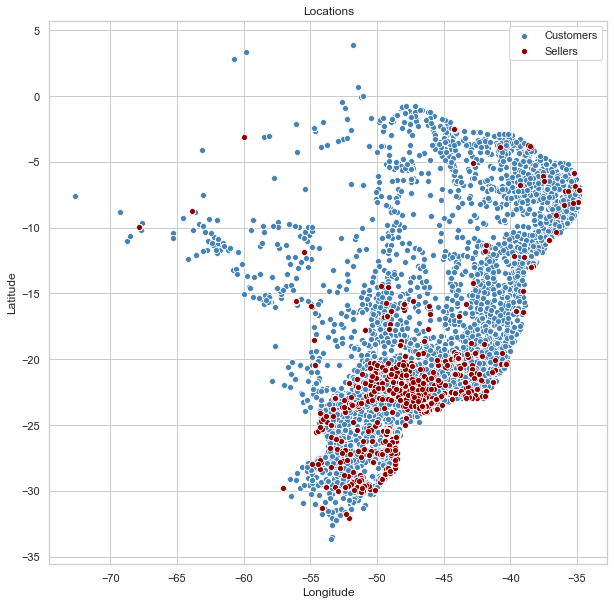

In [198]:
# affichier la nouvelle répartion (carte)
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x='customer_lng',
                y='customer_lat',
                color='steelblue',
                data=df_customers,
                label='Customers')
sns.scatterplot(x='seller_lng',
                y='seller_lat',
                color='darkred',
                data=df_sellers,
                label='Sellers')
plt.title('Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [199]:
# retirer les colonnes obsolètes ?
df_sellers.columns

Index(['seller_id', 'seller_city', 'seller_state', 'seller_lat', 'seller_lng'], dtype='object')

In [200]:
# aggréger aux commandes les localisations customers et sellers
df_orders = df_orders.merge(
    df_sellers,
    how='left',
    left_on=['seller_id'],
    right_on=['seller_id'])
df_orders = df_orders.merge(
    df_customers,
    how='left',
    left_on=['customer_id'],
    right_on=['customer_id'])

In [201]:
df_orders.isna().sum()

order_id                             0
customer_id                          0
order_purchase_timestamp             0
order_purchase_year                  0
order_purchase_month                 0
order_purchase_day                   0
order_purchase_dayofweek             0
order_purchase_hour                  0
order_purchase_month_label           0
order_purchase_dayofweek_label       0
time_zone_hour                       0
time_zone_day                        0
purchase_time_zone                   0
estimated_delivery_time              0
effective_delivery_time              0
delivery_vs_estimated                0
delivery_vs_estimated_lvl            0
items_qty                            0
products_qty                         0
most_important_product               0
total_price                          0
total_freight                        0
freight_percentage                   0
freight_percentage_lvl               0
product_id                           0
seller_id                

In [202]:
# retirer les valeurs manquantes et controler la taille résultante
print(df_orders.shape)
df_orders = df_orders.dropna().copy()
print(df_orders.shape)

(102232, 54)
(100264, 54)


In [203]:
df_orders.sample(7)

,order_id,customer_id,order_purchase_timestamp,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_dayofweek,order_purchase_hour,order_purchase_month_label,order_purchase_dayofweek_label,...,seller_city,seller_state,seller_lat,seller_lng,customer_unique_id,customer_city,customer_state,order_count,customer_lat,customer_lng
4869,a322a4aa3b0a9b47a6760a03ee17ffe8,d312c73308e9c429a61aab82e16b7f6a,2018-01-07 11:53:56,2018,1,7,6,11,Jan,Sun,...,Belo Horizonte,MG,-19.908772,-43.957549,b542893c864fb11225f7105ee3e3f0ca,Pilar,AL,1.0,-9.599891,-35.956748
74114,b921acf09054fd397896f271b0456f01,d2e0e7fa94fbf4e2a54f40fa1dbb13fe,2017-12-27 13:48:41,2017,12,27,2,13,Dec,Wed,...,Cruzeiro,SP,-22.572679,-44.961630,1f4a3983dbe5e967482c2f5569f962e0,Tombos,MG,1.0,-20.871318,-42.124203
33768,5a87769ff430e7d1873e2bb9b3968af3,dd1a12426ed78bacc77fd02911ed1117,2017-09-27 21:24:27,2017,9,27,2,21,Sep,Wed,...,Ibia,MG,-19.515039,-46.561608,cd92e3479a44768cff5131401bd9464c,Sao Paulo,SP,1.0,-23.571253,-46.633911
80936,0dfd5d2f0b9f06775f9630defe80d510,4cc825a34f88e568e8bc28d470687d5a,2017-07-27 22:05:06,2017,7,27,3,22,Jul,Thu,...,Sao Paulo,SP,-23.571253,-46.633911,eb6b0e67076546247fdf737a8a361d0f,Pocos De Caldas,MG,1.0,-21.797201,-46.563999
45527,91a31ae0b2ceeff70549db4b68d0a11e,a7e7ac71f48352503ff2a018aa31002d,2017-06-08 17:50:37,2017,6,8,3,17,Jun,Thu,...,Curitiba,PR,-25.453054,-49.274996,c01a9ddc8ac16b8c24c5a432a627c8e8,Guacui,ES,1.0,-20.772595,-41.675034
53741,d24dbc3d60c85b438cf1b65a937572e3,a6bf868985556478698f51cf124b1567,2018-03-31 08:38:21,2018,3,31,5,8,Mar,Sat,...,Sao Joao De Meriti,RJ,-22.786149,-43.369091,31786275e5f0953e0d19ff73b4ae5630,Rio De Janeiro,RJ,1.0,-22.914911,-43.312877
74421,441cf7155f976d42536081646f9f4714,51c5f0c1e195fc85859adee1046fa34e,2017-10-19 12:33:49,2017,10,19,3,12,Oct,Thu,...,Sao Paulo,SP,-23.571253,-46.633911,e187b9671c855c63c1400ecb2cbe5191,Paraisopolis,MG,1.0,-22.551534,-45.778573


## 7.2. Distance Customer - Seller

Au vu de la virtualisation apportée par le e-commerce, on peut se demander si la notion distance est transparente pour les clients. On émet ici l'hypothèse que la localisation d'un vendeur correspond à celle de ses marchandises.

In [204]:


def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
    """
    seen on stackoverflow.com

    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees or in radians)

    All (lat, lon) coordinates must have numeric dtypes and be of equal length.

    """
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))



In [205]:
# calculer une distance entre customer et seller
df_orders['cust_sell_dist'] = \
    haversine(df_orders['customer_lat'],
              df_orders['customer_lng'],
              df_orders['seller_lat'],
              df_orders['seller_lng'])

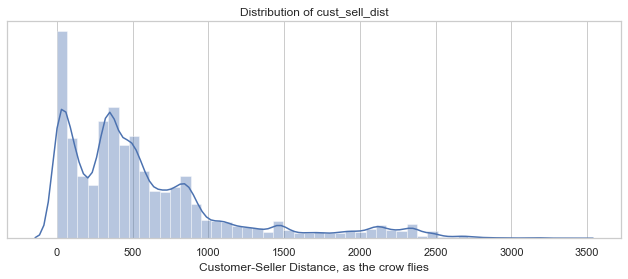

Distance moyenne entre Client et Vendeur : 588


In [206]:
# afficher la distribution de la distance sellers - customers
distribution(df_orders,
             'cust_sell_dist',
             'Customer-Seller Distance, as the crow flies',
             'dist')
print('Distance moyenne entre Client et Vendeur : %d'
      % df_orders['cust_sell_dist'].mean())

In [207]:
# créer / actualiser les commandes répartes par année
orders_2017 = df_orders[(df_orders['order_purchase_year'] == 2017) |
                        (df_orders['order_purchase_year'] == 2016)]
orders_2018 = df_orders[(df_orders['order_purchase_year'] == 2018)]

In [208]:
# observer la variation éventuelle entre 2017 et 2018
print('Variation distance acheteur-vendeur entre 2017 (ref) et 2018 : ' +
      str(round(orders_2017['cust_sell_dist'].mean() - orders_2018['cust_sell_dist'].mean())))

Variation distance acheteur-vendeur entre 2017 (ref) et 2018 : 49


In [209]:
df_orders[df_orders['cust_sell_dist'] == 0].shape

(5373, 55)

un effet de seuil est créé du fait des données calculées pour toutes les commandes intra {ville, état} : on choisit de le remplacer par une valeur moyenne plus représentative d'un trajet de livraison à effectuer. 

In [210]:
df_orders['eq_cust_sell_dist_lvl'] = pd.qcut(
    df_orders['cust_sell_dist'],
    3,
    labels=['Near_Dist',
            'AroundMed_Dist',
            'Far_Dist'])

In [211]:
df_orders['cust_sell_dist'].describe()

count    100264.000000
mean        588.145576
std         579.704869
min           0.000000
25%         177.300959
50%         428.578475
75%         786.209973
max        3396.210394
Name: cust_sell_dist, dtype: float64

In [212]:
pd.qcut(df_orders['cust_sell_dist'], 3)

0          (-0.001, 302.391]
2         (302.391, 616.969]
3         (616.969, 3396.21]
4          (-0.001, 302.391]
5         (302.391, 616.969]
                 ...        
102227    (302.391, 616.969]
102228    (616.969, 3396.21]
102229    (302.391, 616.969]
102230    (302.391, 616.969]
102231    (616.969, 3396.21]
Name: cust_sell_dist, Length: 100264, dtype: category
Categories (3, interval[float64]): [(-0.001, 302.391] < (302.391, 616.969] < (616.969, 3396.21]]

Text(0.5, 1.02, 'Customer-Seller Distance Levels')

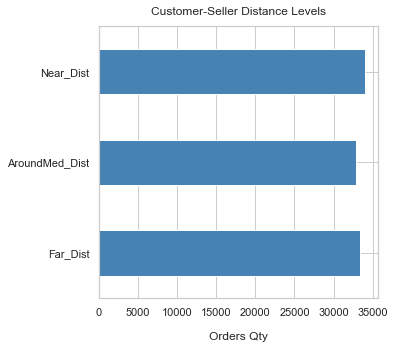

In [213]:
# observer la répartition des niveaux de distance
df_orders['eq_cust_sell_dist_lvl'].value_counts(sort=False).plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Orders Qty', labelpad=14)
plt.title('Customer-Seller Distance Levels', y=1.02)

# 8. Review

Une review permet de remonter à la commande, mais pas au produit évalué, ce qui compromet l'exploitation détaillée.

In [214]:
# montrer un aperçu des review
df_reviews.sample(3)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
65377,fa4d145ad4fd30c0a28bf1b2b6c0d806,61e9a85f2e6a0706d34fc63145418160,5,NaN,NaN,2018-05-03 00:00:00,2018-05-03 23:27:08
9961,46eb30f11c3451a4d21129e6f4d1e1a8,a013a9692edd311c7cd46675f807ab24,5,NaN,NaN,2017-06-30 00:00:00,2017-06-30 23:06:09
57633,99ad16e15b78b452fe4a8e7259825b37,88b7d630e9e888823b36de97deaa6679,1,NaN,Na foto do site consta o produto com 120 cápsu...,2018-04-03 00:00:00,2018-04-05 23:58:49


In [215]:
df_reviews.isna().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       88285
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

In [216]:
# valeur possible des review score
df_reviews['review_score'].unique()

array([4, 5, 1, 3, 2], dtype=int64)

On ne dispose que des produits (bien) évalués !

In [217]:
# nb de commandes unique dans les données de review
df_reviews['order_id'].unique().size

99441

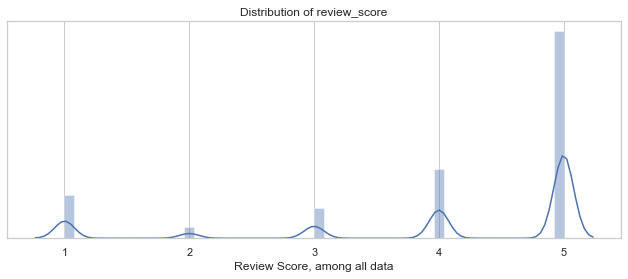

Average Review Score : 4


In [218]:
# afficher la distribution des review_score
distribution(df_reviews,
             'review_score',
             'Review Score, among all data',
             'dist')
print('Average Review Score : %d'
      % df_reviews['review_score'].mean())

Text(0.5, 1.02, 'review_score')

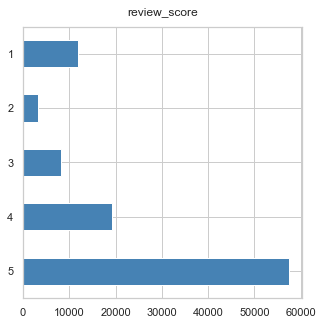

In [219]:
# observer la répartition des review scores
df_reviews['review_score'].value_counts(sort=False).plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.title('review_score', y=1.02)

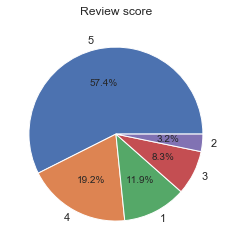

In [220]:
# observer la répartition des types de payment
plt.title('Review score', y=1.02)
plt.pie(df_reviews['review_score'].value_counts(),
        labels=df_reviews['review_score'].value_counts().index,
        autopct='%1.1f%%')
plt.show()

Une exploitation plus fine consisterait à valoriser la longueur du titre et du commentaire pour un aspect plus qualitatif.

## 8.1. Délai de réponse suite à une demande de review
Comportement évaluateur d'un client : délai de réponse.

In [221]:
# formater les champs date
for col in ['review_creation_date', 'review_answer_timestamp']:
    df_reviews[col] = pd.to_datetime(df_reviews[col], format='%Y-%m-%d %H:%M:%S')

In [222]:
df_reviews.isna().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       88285
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

In [223]:
# ordonner les reviews par valeur décroissante de dates
df_reviews = df_reviews.sort_values(by=['order_id', 'review_answer_timestamp'],
                                    ascending=False)

In [224]:
# retirer les doublons en gardant la review la plus récente
df_reviews.drop_duplicates(subset='order_id', keep='first', inplace=True)

In [225]:
# contrôler le traitement
print(df_reviews.shape[0] - df_reviews['order_id'].unique().size)

0


In [226]:
# calculer le délai de réponse (demande d'ajout d'une review)
df_reviews['review_answer_delay'] =\
    (df_reviews['review_answer_timestamp'] - df_reviews['review_creation_date']).dt.days

In [227]:
# retirer les colonnes obsolètes
df_reviews = df_reviews.drop(
    columns=['review_id',
             'review_comment_title',
             'review_comment_message',
             'review_answer_timestamp',
             'review_creation_date'])

In [228]:
# vérification du résultat
df_reviews.sample(3)

,order_id,review_score,review_answer_delay
62849,4b582fb59bf53f9f3e213edbf4917a83,5,3
38077,7327c30a5230ce07bc2c7a695d553a00,5,1
24415,36909b609792791f7f50d7cff2b5a0d6,5,1


In [229]:
df_reviews.isna().sum()

order_id               0
review_score           0
review_answer_delay    0
dtype: int64

In [230]:
df_reviews.describe()

,review_score,review_answer_delay
count,99441.000000,99441.000000
mean,4.070796,2.584186
std,1.359783,9.884802
min,1.000000,0.000000
25%,4.000000,1.000000
50%,5.000000,1.000000
75%,5.000000,3.000000
max,5.000000,518.000000


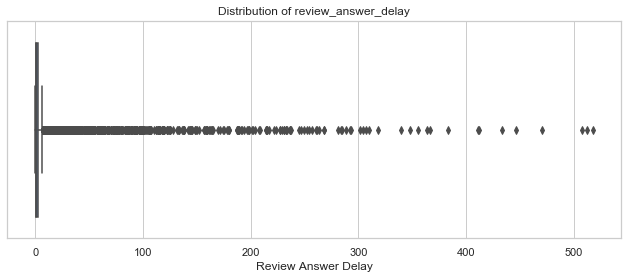

Average Review Answer Delay : 2


In [231]:
# afficher la distribution des délais de réponse
distribution(df_reviews,
             'review_answer_delay',
             'Review Answer Delay',
             'box')
print('Average Review Answer Delay : %d'
      % df_reviews['review_answer_delay'].mean())

In [232]:
# split en 3 niveaux de score
df_reviews['review_answer_delay_lvl'] = pd.qcut(
    df_reviews['review_answer_delay'],
    3,
    labels=['Early_Answer',
            'Nominal_Answer',
            'Late_Answer'])

Text(0.5, 1.02, 'Review Delay ')

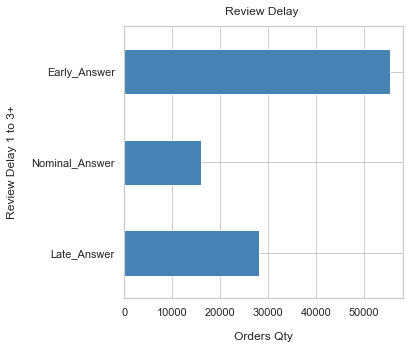

In [233]:
# nouvelle répartition des délais de réponse
df_reviews['review_answer_delay_lvl'].value_counts(sort=False).plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Orders Qty', labelpad=14)
plt.ylabel('Review Delay 1 to 3+', labelpad=14)
plt.title('Review Delay ', y=1.02)

In [234]:
# aggreger aux orders les reviews
df_orders = df_orders.merge(
    df_reviews,
    how='left',
    left_on=['order_id'],
    right_on=['order_id'])

In [235]:
df_orders.isna().sum()

order_id                          0
customer_id                       0
order_purchase_timestamp          0
order_purchase_year               0
order_purchase_month              0
order_purchase_day                0
order_purchase_dayofweek          0
order_purchase_hour               0
order_purchase_month_label        0
order_purchase_dayofweek_label    0
time_zone_hour                    0
time_zone_day                     0
purchase_time_zone                0
estimated_delivery_time           0
effective_delivery_time           0
delivery_vs_estimated             0
delivery_vs_estimated_lvl         0
items_qty                         0
products_qty                      0
most_important_product            0
total_price                       0
total_freight                     0
freight_percentage                0
freight_percentage_lvl            0
product_id                        0
seller_id                         0
product_price                     0
product_freight             

## 8.2. Note moyenne donnée à chaque produit
Influence possible de la note d'un produit sur le comportement client (décompte et note moyenne)

In [236]:
# créer la note (décompte et moyenne)
df_prod_mean_score =\
    df_orders.groupby('product_id',
                      as_index=False).agg({'review_score': ['count',
                                                            'mean']})
df_prod_mean_score.columns = ['product_id',
                              'count',
                              'mean']

# afficher les 10 produits les plus notés
df_prod_mean_score = df_prod_mean_score.sort_values(by='count',
                                                    ascending=False)
df_prod_mean_score[:10]

,product_id,count,mean
19722,aca2eb7d00ea1a7b8ebd4e68314663af,517,4.044487
7738,422879e10f46682990de24d770e7f83d,465,3.997849
17609,99a4788cb24856965c36a24e339b6058,438,3.954338
6619,389d119b48cf3043d311335e499d9c6b,365,4.142466
6360,368c6c730842d78016ad823897a372db,352,4.073864
9695,53759a2ecddad2bb87a079a1f1519f73,341,3.953079
24102,d1c427060a0f73f6b889a5c7c61f2ac4,322,4.332298
9719,53b36df67ebb7c41585e8d54d6772e08,313,4.239617
7239,3dd2a17168ec895c781a9191c1e95ad7,267,4.247191
2514,154e7e31ebfa092203795c972e5804a6,267,4.363296


In [237]:
# retirer les colonnes obsolètes
df_orders = df_orders.drop(
    columns=['product_id'])

In [238]:
# renommer la colonne
df_prod_mean_score = df_prod_mean_score.rename(columns={
    'mean': 'product_review_mean',
    'count': 'product_review_count'})
# rattacher aux commandes la note moyenne
df_orders = df_orders.merge(
    df_prod_mean_score,
    how='left',
    left_on=['most_important_product'],
    right_on=['product_id'])

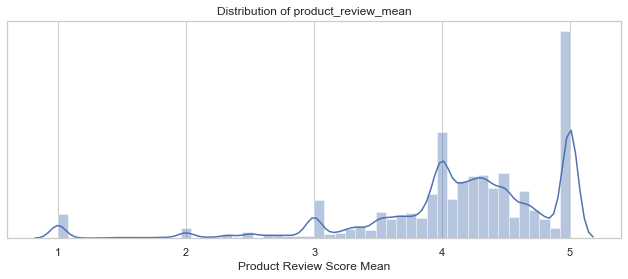

Average Product Review Score : 4


In [239]:
# afficher la distribution des product_review_mean
distribution(df_orders,
             'product_review_mean',
             'Product Review Score Mean',
             'dist')
print('Average Product Review Score : %d'
      % df_orders['product_review_mean'].mean())

In [240]:
# split en 3 niveaux de score
df_orders['product_review_mean_lvl'] = pd.qcut(
    df_orders['product_review_mean'],
    3,
    labels=['Low_Score',
            'Medium_Score',
            'Top_Score'])

Text(0.5, 1.02, 'Score Levels')

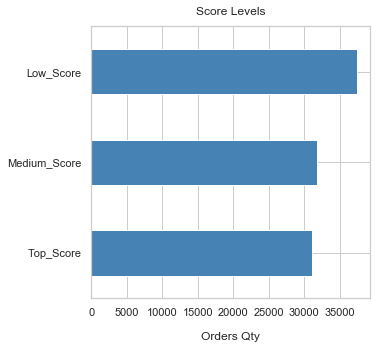

In [241]:
# Contrôler la répartition des niveaux de score
df_orders['product_review_mean_lvl'].value_counts(sort=False).plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Orders Qty', labelpad=14)
plt.title('Score Levels', y=1.02)

In [242]:
# créer / actualiser les commandes répartes par année
orders_2017 = df_orders[(df_orders['order_purchase_year'] == 2017) |
                        (df_orders['order_purchase_year'] == 2016)]
orders_2018 = df_orders[(df_orders['order_purchase_year'] == 2018)]

In [243]:
# observer la variation éventuelle entre 2017 et 2018
print('Variation product_review_mean entre 2017 (ref) et 2018 : ' +
      str(round(orders_2017['product_review_mean'].mean() - orders_2018['product_review_mean'].mean(), 2)))

Variation product_review_mean entre 2017 (ref) et 2018 : 0.01


## 8.3. Note moyenne donnée par chaque client
Comportement évaluateur d'un client : décompte et note moyenne.

In [244]:
# créer la note (décompte et moyenne)
df_cust_mean_score = df_orders.groupby(
    'customer_unique_id',
    as_index=False).agg({'review_score': ['count',
                                          'mean']})
df_cust_mean_score.columns = ['customer_unique_id',
                              'count',
                              'mean']

# afficher les 10 clients donnant les meilleurs notes
df_cust_mean_score = df_cust_mean_score.sort_values(by='count',
                                                    ascending=False)
df_cust_mean_score[:10]

,customer_unique_id,count,mean
69342,c8460e4251689ba205045f3ea17884a1,24,4.0
36578,698e1cf81d01a3d389d96145f7fa6df8,20,1.0
67872,c402f431464c72e27330a67f7b94d4fb,20,1.0
5329,0f5ac8d5c31de21d2f25e24be15bbffb,18,5.0
6263,11f97da02237a49c8e783dfda6f50e8e,15,5.0
48774,8d50f5eadf50201ccdcedfb9e2ac8455,14,5.0
17305,31e412b9fb766b6794724ed17a41dfa6,14,1.0
85754,f7ea4eef770a388bd5b225acfc546604,14,1.0
40698,7582a5a77fc2976628f46a13ec91b375,13,3.0
24350,4644f1b187e390a08b4c66fb16c91364,12,3.0


In [245]:
# rattacher au df via le customer_unique_id
df_cust_mean_score = df_cust_mean_score.rename(columns={
    'count': 'customer_review_count',
    'mean': 'customer_review_mean'})
# rattacher aux clients leur note moyenne
df_orders = df_orders.merge(
    df_cust_mean_score,
    how='left',
    left_on=['customer_unique_id'],
    right_on=['customer_unique_id'])

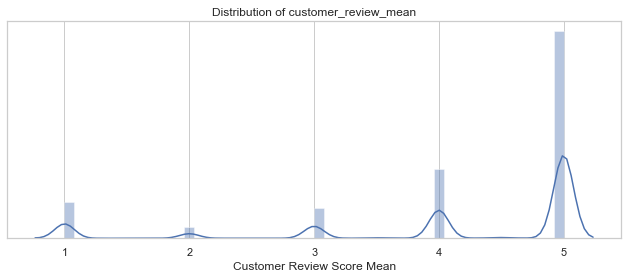

Average Customer Review Score : 4


In [246]:
# afficher la distribution des customer_review_mean
distribution(df_orders,
             'customer_review_mean',
             'Customer Review Score Mean',
             'dist')
print('Average Customer Review Score : %d'
      % df_orders['customer_review_mean'].mean())

In [247]:
# créer / actualiser les commandes répartes par année
orders_2017 = df_orders[(df_orders['order_purchase_year'] == 2017) |
                        (df_orders['order_purchase_year'] == 2016)]
orders_2018 = df_orders[(df_orders['order_purchase_year'] == 2018)]

In [248]:
# observer la variation éventuelle entre 2017 et 2018
print('Variation customer_review_mean entre 2017 (ref) et 2018 : ' +
      str(round(orders_2017['customer_review_mean'].mean() - orders_2018['customer_review_mean'].mean(), 2)))

Variation customer_review_mean entre 2017 (ref) et 2018 : 0.04


## 8.4 Ecart d'évaluation

Le Client évalue-t-il mieux ou moins bien les produits que la moyenne des autres évaluations effectuées pour un produit donné.

In [249]:
# calculer l'écart entre les évaluation moyennes client et globale
df_orders['review_gap'] = df_orders['customer_review_mean'] - df_orders['product_review_mean']

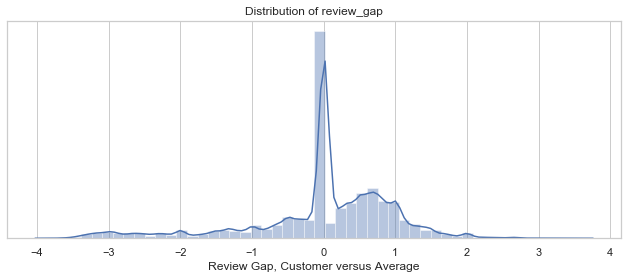

Average Review Gap : 0


In [250]:
# afficher la distribution du review_gap
distribution(df_orders,
             'review_gap',
             'Review Gap, Customer versus Average',
             'dist')
print('Average Review Gap : %d'
      % df_orders['review_gap'].mean())

In [251]:
# créer / actualiser les commandes répartes par année
orders_2017 = df_orders[(df_orders['order_purchase_year'] == 2017) |
                        (df_orders['order_purchase_year'] == 2016)]
orders_2018 = df_orders[(df_orders['order_purchase_year'] == 2018)]

In [252]:
# observer la variation éventuelle entre 2017 et 2018
print('Variation review_gap entre 2017 (ref) et 2018 : ' +
      str(round(orders_2017['review_gap'].mean() - orders_2018['review_gap'].mean(), 2)))

Variation review_gap entre 2017 (ref) et 2018 : 0.03


L'écart moyen est logiquement nul du fait que ce sont les notes des clients qui sont prises en compte pour le même scope de commandes, en revanche l'étalement de l'écart introduit une appréciation différente.

In [253]:
# catégoriser les écart de notation


def note(val):
    if (val == 0):
        return 'Same_Review'
    elif (val < 0):
        return 'Worst_Review'
    else:
        return 'Better_Review'


# dériver un feature identifiant qu'il y a plus de 3 usages
df_orders['review_gap_cat'] = df_orders['review_gap'].apply(note)

Text(0.5, 1.02, 'Review Gap Levels Customers versus Average')

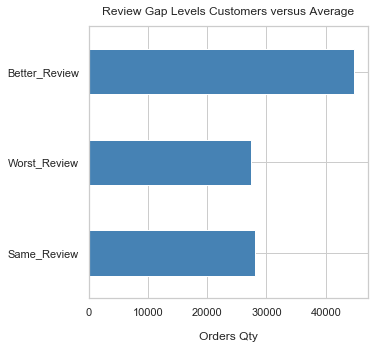

In [254]:
# observer la répartition écarts de score
df_orders['review_gap_cat'].value_counts(sort=False).plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Orders Qty', labelpad=14)
plt.title('Review Gap Levels Customers versus Average', y=1.02)

# 9. Données consolidées et Orientation Retenue

L'EDA a révélé des features et leurs dérivés, que nous allons catégoriser pour appliquer des traitements systématiques et tester leur pertinence dans l'approche de segmentation. <br/>
A ce stade et pour aller en avant, vu les donées partielles ne permettant pas de suivi longitudinal client : on ne fera pas de "moyenne" par client, ni d'ancienneté, ni fréquence, mais on retiendra son dernier achat, et pour ce dernier achat le produit le plus cher de sa commande, en contrôlant la taille du dataset retenu.

In [255]:
df_orders.columns

Index(['order_id', 'customer_id', 'order_purchase_timestamp',
       'order_purchase_year', 'order_purchase_month', 'order_purchase_day',
       'order_purchase_dayofweek', 'order_purchase_hour',
       'order_purchase_month_label', 'order_purchase_dayofweek_label',
       'time_zone_hour', 'time_zone_day', 'purchase_time_zone',
       'estimated_delivery_time', 'effective_delivery_time',
       'delivery_vs_estimated', 'delivery_vs_estimated_lvl', 'items_qty',
       'products_qty', 'most_important_product', 'total_price',
       'total_freight', 'freight_percentage', 'freight_percentage_lvl',
       'seller_id', 'product_price', 'product_freight', 'charm_price',
       'charmed_price', 'product_name_length', 'product_description_length',
       'product_photos_qty', 'product_weight_g', 'product_size',
       'rational_category', 'main_payment_type', 'main_payment_value',
       'payment_sequence_size', 'payment_installments_size', 'payment_total',
       'main_payment_type_cat', 'N_S

In [256]:
# retirer les colonnes redondantes
df_orders = df_orders.drop(
    columns=['product_id'])

In [257]:
# contrôler l'aggrégation sur la base des coûts
cols = ['total_price',
        'total_freight',
        'payment_total']
df_orders[cols].sample(7)

,total_price,total_freight,payment_total
35004,119.8,36.60,156.40
81528,99.9,16.95,116.85
76866,80.0,28.20,108.20
83655,54.9,10.99,65.89
83355,349.0,27.19,376.19
93340,134.9,13.28,148.18
70547,117.7,23.32,141.02


## 9.1. Simplification à la commande la plus récente

In [258]:
df_orders = df_orders.sort_values(by='order_purchase_timestamp',
                                  ascending=False)
df_orders.head(3)

,order_id,customer_id,order_purchase_timestamp,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_dayofweek,order_purchase_hour,order_purchase_month_label,order_purchase_dayofweek_label,...,review_score,review_answer_delay,review_answer_delay_lvl,product_review_count,product_review_mean,product_review_mean_lvl,customer_review_count,customer_review_mean,review_gap,review_gap_cat
88765,35a972d7f8436f405b56e36add1a7140,898b7fee99c4e42170ab69ba59be0a8b,2018-08-29 15:00:37,2018,8,29,2,15,Aug,Wed,...,5,9,Late_Answer,82,4.353659,Medium_Score,1,5.0,0.646341,Better_Review
70208,03ef5dedbe7492bdae72eec50764c43f,496630b6740bcca28fce9ba50d8a26ef,2018-08-29 14:52:00,2018,8,29,2,14,Aug,Wed,...,3,0,Early_Answer,1,3.000000,Low_Score,1,3.0,0.000000,Same_Review
31772,168626408cb32af0ffaf76711caae1dc,6e353700bc7bcdf6ebc15d6de16d7002,2018-08-29 14:18:28,2018,8,29,2,14,Aug,Wed,...,5,2,Nominal_Answer,29,4.172414,Medium_Score,1,5.0,0.827586,Better_Review


In [259]:
# observer le nb de commandes multiples avant simplification
df_orders[df_orders['order_count'] > 1].shape[0]

6506

In [260]:
# ne garder que la dernière commande et surveiller la taille de dataset
print(df_orders.shape)
df_orders.drop_duplicates(subset='customer_unique_id',
                          keep='first',
                          inplace=True)
print(df_orders.shape)

(100264, 65)
(88494, 65)


In [261]:
# observer le nb de commandes multiples après simplification
df_orders[df_orders['order_count'] > 1].shape[0]

2942

In [301]:
# conditionner les données "customer-centric"
data = df_orders.copy()

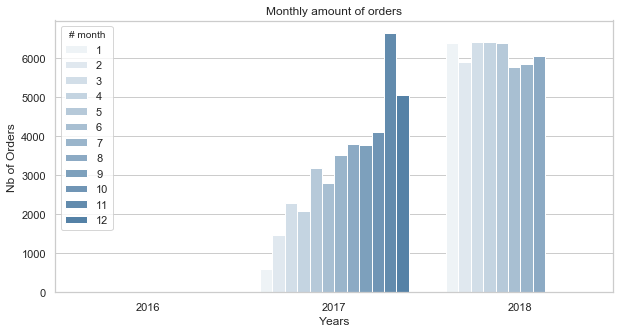

In [263]:
# afficher l'évolution des commandes filtrées
plt.figure(figsize=(10, 5))
ax = sns.countplot(x='order_purchase_year',
                   hue='order_purchase_month',
                   data=data,
                   color='Steelblue')
ax.set(xlabel='Years',
       ylabel='Nb of Orders',
       title='Monthly amount of orders')
plt.legend(title='# month', loc='upper left')
plt.show()

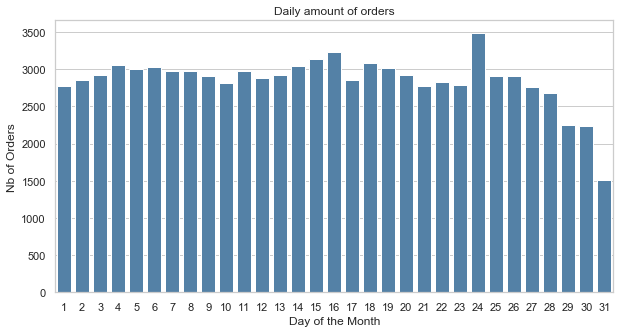

1:80: E501 line too long (80 > 79 characters)


In [264]:
# afficher l'évolution des commandes filtrées selon les jours du mois (en cumul)
plt.figure(figsize=(10, 5))
ax = sns.countplot(x='order_purchase_day',
                   data=data,
                   color='Steelblue')
ax.set(xlabel='Day of the Month',
       ylabel='Nb of Orders',
       title='Daily amount of orders')
plt.show()

In [265]:
# Pour afficher toutes les colonnes
pd.options.display.max_columns = 100

In [266]:
data.columns

Index(['order_id', 'customer_id', 'order_purchase_timestamp',
       'order_purchase_year', 'order_purchase_month', 'order_purchase_day',
       'order_purchase_dayofweek', 'order_purchase_hour',
       'order_purchase_month_label', 'order_purchase_dayofweek_label',
       'time_zone_hour', 'time_zone_day', 'purchase_time_zone',
       'estimated_delivery_time', 'effective_delivery_time',
       'delivery_vs_estimated', 'delivery_vs_estimated_lvl', 'items_qty',
       'products_qty', 'most_important_product', 'total_price',
       'total_freight', 'freight_percentage', 'freight_percentage_lvl',
       'seller_id', 'product_price', 'product_freight', 'charm_price',
       'charmed_price', 'product_name_length', 'product_description_length',
       'product_photos_qty', 'product_weight_g', 'product_size',
       'rational_category', 'main_payment_type', 'main_payment_value',
       'payment_sequence_size', 'payment_installments_size', 'payment_total',
       'main_payment_type_cat', 'N_S

In [292]:
data.select_dtypes(include='int64').columns

Index(['order_purchase_year', 'order_purchase_month', 'order_purchase_day',
       'order_purchase_dayofweek', 'order_purchase_hour',
       'estimated_delivery_time', 'effective_delivery_time',
       'delivery_vs_estimated', 'charm_price', 'payment_sequence_size',
       'payment_installments_size', 'review_score', 'review_answer_delay',
       'product_review_count', 'customer_review_count'],
      dtype='object')

In [293]:
data.select_dtypes(include='float64').columns

Index(['total_price', 'total_freight', 'freight_percentage', 'product_price',
       'product_freight', 'product_name_length', 'product_description_length',
       'product_weight_g', 'product_size', 'main_payment_value',
       'payment_total', 'N_SCALE_payment_total', 'seller_lat', 'seller_lng',
       'order_count', 'customer_lat', 'customer_lng', 'cust_sell_dist',
       'product_review_mean', 'customer_review_mean', 'review_gap',
       'N_RG_payment_total', 'N_RG_freight_percentage',
       'N_RG_product_review_mean', 'N_RG_review_gap',
       'N_RG_delivery_vs_estimated', 'N_RG_cust_sell_dist'],
      dtype='object')

In [302]:
data.select_dtypes(include='category').columns

Index(['purchase_time_zone', 'delivery_vs_estimated_lvl',
       'freight_percentage_lvl', 'product_photos_qty', 'eq_payment_lvl',
       'eq_cust_sell_dist_lvl', 'review_answer_delay_lvl',
       'product_review_mean_lvl'],
      dtype='object')

In [298]:
data.select_dtypes(include='object').columns

Index(['order_id', 'customer_id', 'order_purchase_month_label',
       'order_purchase_dayofweek_label', 'time_zone_hour', 'time_zone_day',
       'purchase_time_zone', 'items_qty', 'products_qty',
       'most_important_product', 'seller_id', 'charmed_price',
       'rational_category', 'main_payment_type', 'main_payment_type_cat',
       'seller_city', 'seller_state', 'customer_unique_id', 'customer_city',
       'customer_state', 'review_gap_cat'],
      dtype='object')

## 9.2. Récapitulatif et priorisation des features

In [268]:
new_index = ['customer_unique_id']

temporal_cut_features = ['order_purchase_year', 'order_purchase_month']

useless_features = ['order_id',
                    'customer_id',
                    'order_purchase_timestamp',
                    'order_purchase_month_label'
                    'order_purchase_day',
                    'order_purchase_dayofweek_label',
                    'time_zone_hour',
                    'time_zone_day',
                    'most_important_product',
                    'seller_id',
                    'seller_city',
                    'customer_city',
                    'product_review_count',
                    'review_score',
                    'seller_lat',
                    'seller_lng',
                    'customer_lat',
                    'customer_lng']

for_lvl_features = ['delivery_vs_estimated_lvl',
                    'product_desc_length_lvl',
                    'product_name_length_lvl',
                    'product_photos_qty_lvl',
                    'product_size_lvl',
                    'product_weight_g_lvl',
                    'product_density_lvl',
                    'freight_percentage_lvl',
                    'eq_freight_percentage_lvl',
                    'payment_lvl',
                    'eq_payment_lvl',
                    'cust_sell_dist_lvl',
                    'eq_cust_sell_dist_lvl',
                    'review_gap_lvl']

to_encode_features = ['rational_category',
                      'purchase_time_zone',
                      'main_payment_type',
                      'main_payment_type_cat']

In [269]:
# fonction de one-hot encoding pour les données catégorielles


def onehot(data, feature):
    # transforme en binaire les catégories
    temp_df = pd.get_dummies(data[feature])
    # préfixe le nouveau feature
    temp_df = temp_df.add_prefix(feature + '_')
    # ajoute le nouveau feature
    data = pd.concat([data, temp_df], axis=1)
    # retire le feature dans sa version d'origine
    # data.drop(feature, axis=1, inplace=True)
    # retourne le nouveau dataframe
    return data



In [270]:
# appliquer l'encoding des variables catégorielles retenues
for i in to_encode_features:
    print(i)
    data = onehot(data, i)
    print(data.shape)

rational_category
(88494, 80)
purchase_time_zone
(88494, 85)
main_payment_type
(88494, 89)
main_payment_type_cat
(88494, 91)


In [271]:
# organiser les features catégoriels encodés
cat_feat_product = data.columns[data.columns.str.contains(
    'rational_category_')].tolist()
cat_feat_order = data.columns[data.columns.str.contains(
    'purchase_time_zone_')].tolist()
cat_feat_payment = data.columns[data.columns.str.contains(
    'main_payment_type')].tolist()
cat_feat_geoloc = data.columns[data.columns.str.contains(
    '_state_')].tolist()

In [272]:
# passer le customer_unique_id en index
data = data.rename(index=data['customer_unique_id'])

In [273]:
# fonction de transformation des features numériques


def rankgauss(data, feature):
    # crée une instance de quatiletransformer
    transformer = QuantileTransformer(n_quantiles=100,
                                      random_state=1111,
                                      output_distribution='normal')
    # adpate au feature
    transformer.fit(data[[feature]])
    # préfixe le nouveau feature
    newfeat = str('N_RG_' + feature)
    # ajoute le nouveau feature transformé
    data[newfeat] = transformer.transform(data[[feature]])
    # retire le feature dans sa version d'origine
    # data.drop(feature, axis=1, inplace=True)
    # retourne le nouveau dataframe
    return data

In [274]:
# prioriser les features numériques exploitables
feature_selection = ['payment_total',
                     'freight_percentage',
                     'product_review_mean',
                     'review_gap',
                     'delivery_vs_estimated',
                     'cust_sell_dist']

In [275]:
# appliquer le rankgauss aux features numériques
for i in feature_selection:
    print(i)
    data = rankgauss(data, i)
    print(data.shape)

payment_total
(88494, 92)
freight_percentage
(88494, 93)
product_review_mean
(88494, 94)
review_gap
(88494, 95)
delivery_vs_estimated
(88494, 96)
cust_sell_dist
(88494, 97)


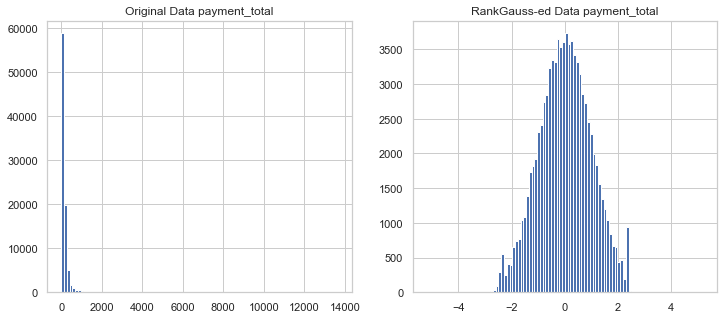

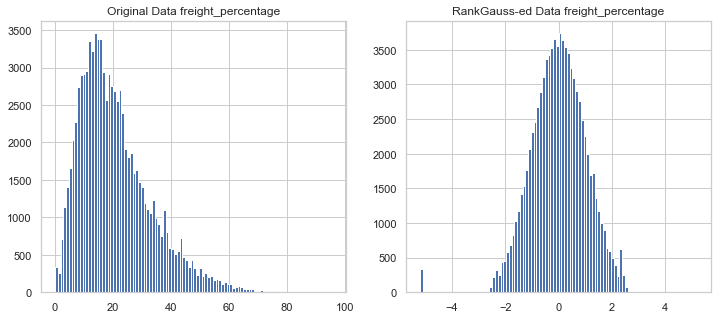

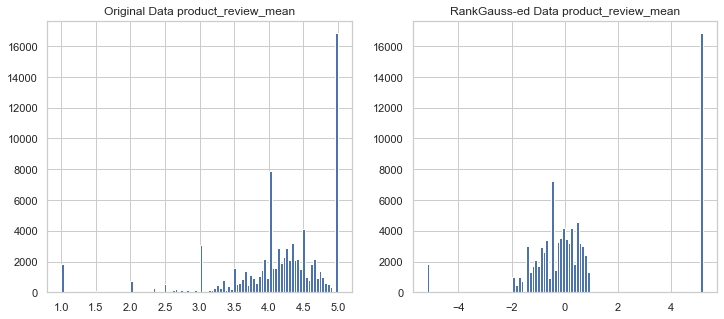

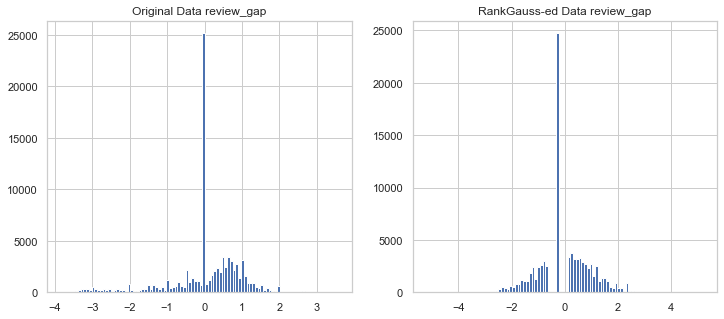

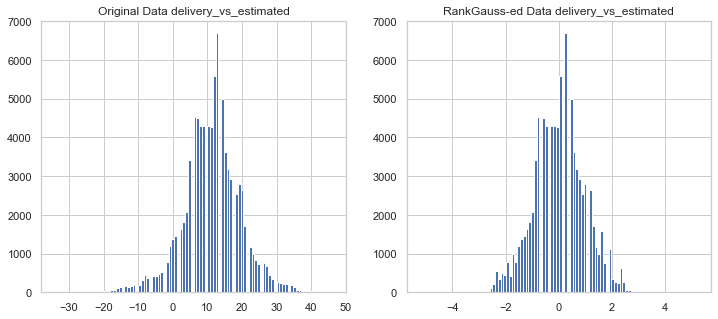

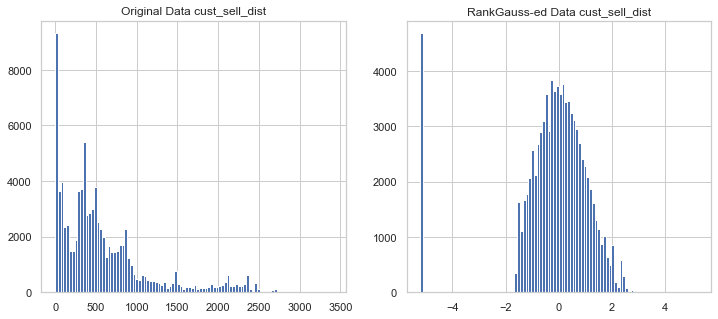

In [276]:
# observer le résultat du traitement rankgauss:
for i in feature_selection:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12, 5])
    ax1.hist(data[i], bins=100)
    ax1.title.set_text(str('Original Data ' + i))
    ax2.hist(data[str('N_RG_' + i)], bins=100)
    ax2.title.set_text(str('RankGauss-ed Data ' + i))
    plt.show()

In [277]:
std_feature_selection = data.columns[data.columns.str.contains(
    'N_RG_')].tolist()

In [278]:
data_std_selection = data.filter(std_feature_selection)

In [279]:
data_std_selection.head(3)

,N_RG_payment_total,N_RG_freight_percentage,N_RG_product_review_mean,N_RG_review_gap,N_RG_delivery_vs_estimated,N_RG_cust_sell_dist
24ac2b4327e25baf39f2119e4228976a,-0.132661,-0.965920,0.192247,0.645504,-0.889495,-0.772606
b701bebbdf478f5500348f03aff62121,-1.591448,0.525579,-1.434200,-0.242903,-1.096804,-1.582677
7febafa06d9d8f232a900a2937f04338,-0.682746,0.528679,-0.131151,0.939421,-0.063341,-0.007257


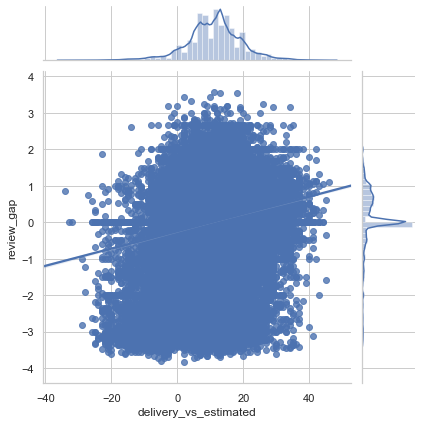

In [280]:
sns.jointplot('delivery_vs_estimated', 'review_gap', data=data, kind='reg')

# selection des features

In [281]:
std_feature_selection

['N_RG_payment_total',
 'N_RG_freight_percentage',
 'N_RG_product_review_mean',
 'N_RG_review_gap',
 'N_RG_delivery_vs_estimated',
 'N_RG_cust_sell_dist']

In [282]:
# projection sur les données
data_correlation = data.filter(std_feature_selection)
data_correlation.shape

(88494, 6)

(6.0, 0.0)

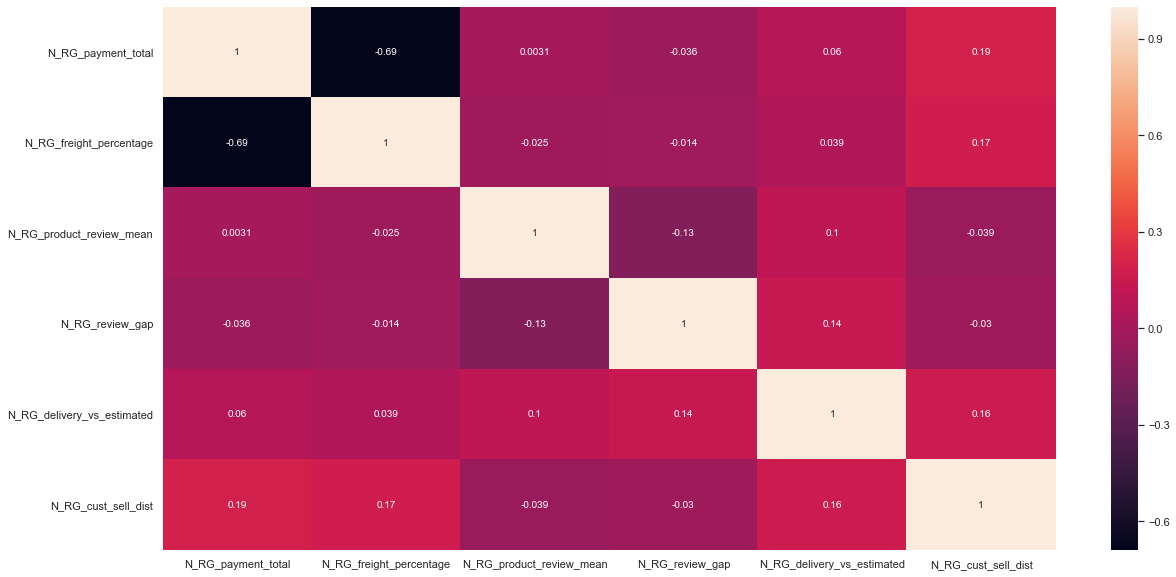

In [283]:
# visualiser la corrélation des features
plt.figure(figsize=(20, 10))
ax = sns.heatmap(data_correlation.corr(method='pearson'), annot=True)
plt.yticks(rotation=0)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [284]:
# exporter les données
data.to_csv('Data/data.csv', index=False)

In [285]:
STOP

NameError: name 'STOP' is not defined

## Aperçu K-Means

In [ ]:
sse = {}
silhouette = {}
for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit_predict(data_std_selection)
    silhouette[k] = metrics.silhouette_score(data_std_selection,
                                             kmeans.labels_)
    sse[k] = kmeans.inertia_

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.grid(False)
ax2.grid(False)
ax1.plot(list(sse.keys()),
         list(sse.values()),
         'v-',
         markersize=10,
         color='steelblue')
ax2.plot(list(silhouette.keys()),
         list(silhouette.values()),
         '^-',
         markersize=10,
         color='red')
ax1.set_xlabel('Nb of clusters')
ax1.set_ylabel('Elbow criterion', color='steelblue')
ax2.set_ylabel('Silhouette score', color='red')
plt.show()

In [ ]:
# on complète l'observation par l'analyse du score de Davies-Bouldin
dbs = {}
for k in range(2, 5):
    kmeans = KMeans(n_clusters=k,
                    random_state=42)
    kmeans.fit(data_std_selection)
    dbs[k] = metrics.davies_bouldin_score(
        data_std_selection,
        kmeans.labels_)

In [ ]:
plt.title('Davies-Bouldin Score')
sns.pointplot(x=list(dbs.keys()), y=list(dbs.values()))